The first step is to load the data and libraries and make sure that it is clean and usable.

The research question: Which products exhibit the highest and lowest sales volumes across different sales channels, and what factors contribute to these variations?

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [3]:

# Define file paths 
user_transactions_file_directory = 'C:/Users/user/Downloads/TaoYin_User_Transactions_v2.parquet'
item_features_file_directory = "C:/Users/user/Downloads/Tao Yin_Item_features_cleaned.parquet"

# Read the parquet files
df_ut = pd.read_parquet(user_transactions_file_directory)
df_if_cleaned = pd.read_parquet(item_features_file_directory)

In [5]:
# # Rename columns for consistency
# df_if_cleaned.rename(columns={'Articlenr': 'articlenr'}, inplace=True)
# df_ut.rename(columns={'artikelnr': 'articlenr'}, inplace=True)

# # Merge the DataFrames on 'articlenr', including the additional columns
# merged_df = pd.merge(
#     df_ut,
#     df_if_cleaned[['articlenr', 'ETIM', 'statistiek_hoofdgroep', 'statistiek_subgroep']],
#     on='articlenr',
#     how='inner'
# )
# merged_df.head(5)

Before diving into deep analysis, it is crucial to understand the structure of the data. Its columns and the number of rows—which allows us to determine what types of analyses are possible and how we need to prepare the data.

In [6]:
# calculating the sales_sum
df_ut['sales_sum'] = df_ut['volume'] * (df_ut['sum2'] - df_ut['sum1'])

# Calculate the median and Median Absolute Deviation (MAD) for the 'sales_sum' column
# Replace 'sales_sum' with the actual sales column in your merged_df if different
median = df_ut['sales_sum'].median()
mad = (df_ut['sales_sum'] - median).abs().median()

# Calculate modified Z-scores for outlier detection
df_ut['Sales Z-Score'] = 0.6745 * (df_ut['sales_sum'] - median) / mad

# Identify outliers where the absolute Z-score is greater than 3.5
outliers = df_ut[df_ut['Sales Z-Score'].abs() > 3.5]

# Get a list of customer IDs that are outliers (replace 'customer_id' with the correct column name for customer IDs)
outlier_customers = outliers['customer'].tolist()  # Replace 'customer_id' with the actual column name

# Print the list of outliers
print("Outliers using Z-score:")
print(outliers)
print("\nList of Outlier Customer IDs:")
print(outlier_customers)

Outliers using Z-score:
        customer  invoice invoice_date  articlenr  volume     sum1     sum2  \
0           2284  1187467   2020-01-02   32879960      24   343.73   362.30   
1           2284  1187467   2020-01-02   32879962      60  1067.64  1119.96   
2           2284  1187467   2020-01-02   32841810     120  2214.00  2408.40   
16           812  1187640   2020-01-03   26080132     100    42.63    49.42   
17           812  1187640   2020-01-03   26080116     100    42.63    49.42   
...          ...      ...          ...        ...     ...      ...      ...   
492706      1184  1596593   2024-09-18   26810732     200   328.03   177.52   
492707      1184  1596593   2024-09-18   32202844     100   283.66   172.96   
492710      1571  1596665   2024-09-19   27243544     200   559.10   434.30   
492711      1571  1596666   2024-09-19   26811430     100   296.22   260.51   
492726       441  1596745   2024-09-19   34100450       4   590.03   619.53   

        postcode_delivery  

In [7]:
# List of columns to drop
columns_to_drop = ['variable', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

# Drop the unnecessary columns
df = df_ut.drop(columns=columns_to_drop)

# Display the first few rows of the DataFrame after dropping columns
print("First few rows of the DataFrame after dropping unnecessary columns:")
df_ut.head()

First few rows of the DataFrame after dropping unnecessary columns:


,customer,invoice,invoice_date,articlenr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,...,count,mean,std,min,25%,50%,75%,max,sales_sum,Sales Z-Score
0,2284,1187467,2020-01-02,32879960,24,343.73,362.30,80413,80413,Tel 86041,...,492731.0,232.402877,66018.754796,0.0,12.88,38.04,110.40,45962439.93,445.68,14.174984
1,2284,1187467,2020-01-02,32879962,60,1067.64,1119.96,80413,80413,Tel 86041,...,492731.0,259.420057,80327.164607,0.0,12.47,37.08,110.42,55998378.22,3139.20,99.751020
2,2284,1187467,2020-01-02,32841810,120,2214.00,2408.40,80413,80413,Tel 86041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23328.00,741.170973
3,1704,1191447,2020-01-17,36866802,1,21.52,19.32,81724,81724,OTC 81812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.20,-0.054646
4,45,1187691,2020-01-03,34360272,4,28.91,28.49,81796,81796,Web Order,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.68,-0.038125


In [8]:
# Step 1: Filter out outliers to calculate min and max values without them
filtered_df = df_ut[~df_ut['customer'].isin(outlier_customers)]  # Replace 'customer_id' with actual ID column

min_profit = filtered_df['sales_sum'].min()
max_profit = filtered_df['sales_sum'].max()

# Step 2: Create evenly spaced bins for sales_sum using the min and max values
bins = np.linspace(min_profit, max_profit, num=6)  # Creates 5 equal-width intervals
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Step 3: Create sales categories based on these equal-width bins
df_ut['sales_category'] = pd.cut(df_ut['sales_sum'], bins=bins, labels=labels, include_lowest=True)

# Bring the outliers back into the categories
df_ut.loc[df_ut['sales_sum'] > max_profit, 'sales_category'] = 'Very High'
df_ut.loc[df_ut['sales_sum'] < min_profit, 'sales_category'] = 'Very Low'

# Step 4: Sort by sales category and volume
sorted_df = df_ut.sort_values(by=['sales_category', 'sales_sum'], ascending=[True, False]).reset_index(drop=True)

# Step 5: Display the sorted DataFrame and category counts
print("Sales Category Counts:")
print(sorted_df['sales_category'].value_counts())

# Display a sample of the sorted DataFrame, showing customer_id, sales_sum, and sales_category
print("\nTop 10 Sorted by Sales Category and Sales Sum:")
print(sorted_df[['customer', 'sales_sum', 'sales_category']].head(10))

Sales Category Counts:
sales_category
Medium       247326
Very Low      97604
Very High     82978
Low           32673
High          32150
Name: count, dtype: int64

Top 10 Sorted by Sales Category and Sales Sum:
   customer  sales_sum sales_category
0        14     -66.08       Very Low
1        14     -66.08       Very Low
2       731     -66.08       Very Low
3        45     -66.08       Very Low
4        14     -66.08       Very Low
5      1598     -66.08       Very Low
6       218     -66.08       Very Low
7      1495     -66.10       Very Low
8       317     -66.11       Very Low
9      2386     -66.12       Very Low


In [9]:
print(df_ut.head())


   customer  invoice invoice_date  articlenr  volume     sum1     sum2  \
0      2284  1187467   2020-01-02   32879960      24   343.73   362.30   
1      2284  1187467   2020-01-02   32879962      60  1067.64  1119.96   
2      2284  1187467   2020-01-02   32841810     120  2214.00  2408.40   
3      1704  1191447   2020-01-17   36866802       1    21.52    19.32   
4        45  1187691   2020-01-03   34360272       4    28.91    28.49   

   postcode_delivery  postcode_customer    channel  ...        mean  \
0              80413              80413  Tel 86041  ...  232.402877   
1              80413              80413  Tel 86041  ...  259.420057   
2              80413              80413  Tel 86041  ...         NaN   
3              81724              81724  OTC 81812  ...         NaN   
4              81796              81796  Web Order  ...         NaN   

            std  min    25%    50%     75%          max  sales_sum  \
0  66018.754796  0.0  12.88  38.04  110.40  45962439.93   

In [10]:
import pandas as pd

# Replace null values with the mean of the respective columns
df_filled = df.fillna(df.mean(numeric_only=True))

# Display the first few rows of the DataFrame after replacing null values
print("First few rows of the DataFrame after replacing null values with mean:")
df_filled.head()

First few rows of the DataFrame after replacing null values with mean:


,customer,invoice,invoice_date,articlenr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,z_score_sum1,z_score_sum2,sales_sum,Sales Z-Score
0,2284,1187467,2020-01-02,32879960,24,343.73,362.30,80413,80413,Tel 86041,0.001686,0.001281,445.68,14.174984
1,2284,1187467,2020-01-02,32879962,60,1067.64,1119.96,80413,80413,Tel 86041,0.012652,0.010713,3139.20,99.751020
2,2284,1187467,2020-01-02,32841810,120,2214.00,2408.40,80413,80413,Tel 86041,0.030016,0.026753,23328.00,741.170973
3,1704,1191447,2020-01-17,36866802,1,21.52,19.32,81724,81724,OTC 81812,-0.003194,-0.002989,-2.20,-0.054646
4,45,1187691,2020-01-03,34360272,4,28.91,28.49,81796,81796,Web Order,-0.003082,-0.002875,-1.68,-0.038125


This line of code is used to inspect the dataset for missing values. Identifying missing values in my dataset is a crucial step in the data analysis process. If the dataset has missing values, it may affect the accuracy of the analysis and any conclusions drawn from it. Missing values in key columns such as volume or channel can directly affect the validity of calculations and insights derived from the analysis. If these columns have missing values, it is crucial to either impute or exclude those entries to ensure correct aggregation when determining the highest and lowest sales volumes.


This step is crucial for cleaning the dataset that I will be using to conduct the analysis. If duplicates are found, I may want to remove them or aggregate them appropriately. For example, if duplicates represent multiple sales of the same product, i could sum their volume to get an accurate total.

In [11]:
total_sales = sorted_df.groupby(['articlenr', 'channel'])['volume'].sum().reset_index()


By grouping the data by articlenr and channel, I can determine the sales performance of each product in different channels. This allows me to compare products across channels, which is central to understanding which products are popular or underperforming in particular sales environments (e.g., online store, in-store, third-party platforms). By calculating total sales volume, I can easily identify the highest and lowest sales for each product across channels. This helps to identify which products need more marketing attention or changes in pricing strategy.

In [12]:
max_sales_product = total_sales.loc[total_sales['volume'].idxmax()]
min_sales_product = total_sales.loc[total_sales['volume'].idxmin()]


This line of code helps identify the least and the most popular products and channel combination.
Knowing which products have the lowest and highest sales volume is important because it provides insights into:
-Which products are underperforming in specific channels.
-It helps in decision-making regarding discontinuation or revision of products.
-It informs whether pricing, marketing, or promotion adjustments are needed.
In addition: The top-performing product give a good idea about which products to allocate more inventory for and which channels to focus on for future promotional campaigns.
Knowing the least performing product helps decide whether to modify the product, run new promotions, or discontinue it.

In [13]:
# Group data by 'channel' and find the indices of the max and min sales volume for each channel
max_sales_per_channel = df_ut.loc[sorted_df.groupby('channel')['volume'].idxmax()]
min_sales_per_channel = df_ut.loc[sorted_df.groupby('channel')['volume'].idxmin()]

# Print the results
print("Products with the Highest Sales Volume per Channel:")
print(max_sales_per_channel)

print("\nProducts with the Lowest Sales Volume per Channel:")
print(min_sales_per_channel)


Products with the Highest Sales Volume per Channel:
        customer  invoice invoice_date  articlenr  volume    sum1    sum2  \
409753      2157  1528174   2023-10-17   34208006     400  388.80  416.64   
94727         82  1287088   2021-01-29   35809944       1  131.11  113.87   
95426       2453  1282216   2021-01-12   35586552       2   31.62   35.98   
97601       1728  1301339   2021-03-23   32202514     100   77.53   61.93   
97086       2030  1291244   2021-02-16   34287530      10  528.19  501.72   
97559       2157  1300779   2021-03-23   32200038       2   97.85  129.19   
428613       506  1486720   2023-04-20   32608218       1    1.79    1.43   
72006         82  1458230   2022-12-22   32203444     100  194.73  153.02   
91310       2453  1251065   2020-09-08   35725532       1    3.52    4.13   
410080       183  1480880   2023-03-28   32201030     100   84.42   26.50   
128102      2453  1206276   2020-03-10   35564476       1   27.07   32.22   
409757      2401  152923

This step helps to dive deeper into sales performance for each sales channel. Instead of just looking at the overall maximum and minimum values across all channels, we are examining the individual performance within each channel. This allows me to see if certain products perform better in specific channels and if any products have notably low performance across different channels.

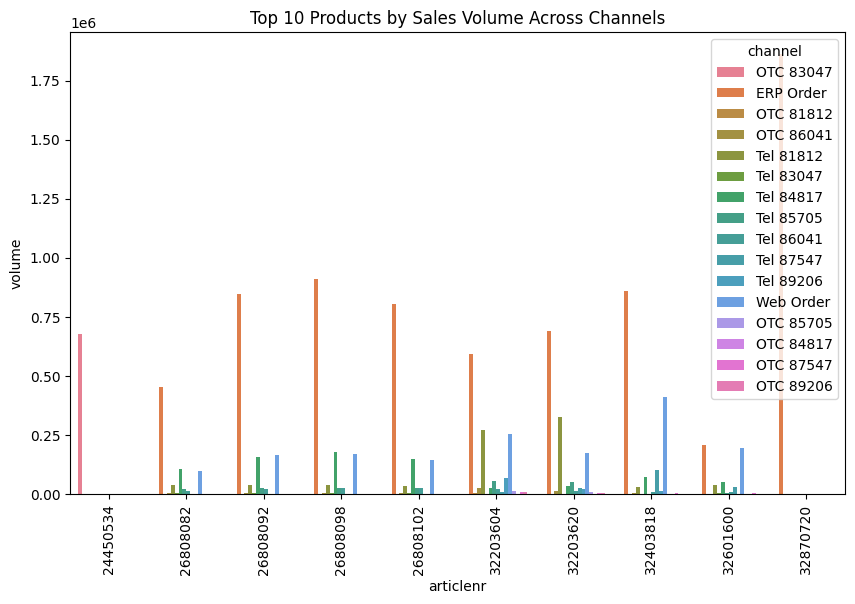

In [14]:
total_sales = df_ut.groupby(['articlenr', 'channel'])['volume'].sum().reset_index()

top_10_products = total_sales.groupby('articlenr')['volume'].sum().nlargest(10).index
filtered_data = total_sales[total_sales['articlenr'].isin(top_10_products)]

plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_data, x='articlenr', y='volume', hue='channel')
plt.xticks(rotation=90)
plt.title("Top 10 Products by Sales Volume Across Channels")
plt.show()


This step allows me to focus the analysis on the top 10 products across all channels. We can then see how these products are performing across different sales channels. It is a useful segmentation strategy that helps to narrow down the dataset and focus on key products driving the sales. If certain products are popular only in specific channels, the client may want to boost marketing efforts in underperforming channels or focus on particular products for particular channels to maximize effectiveness.

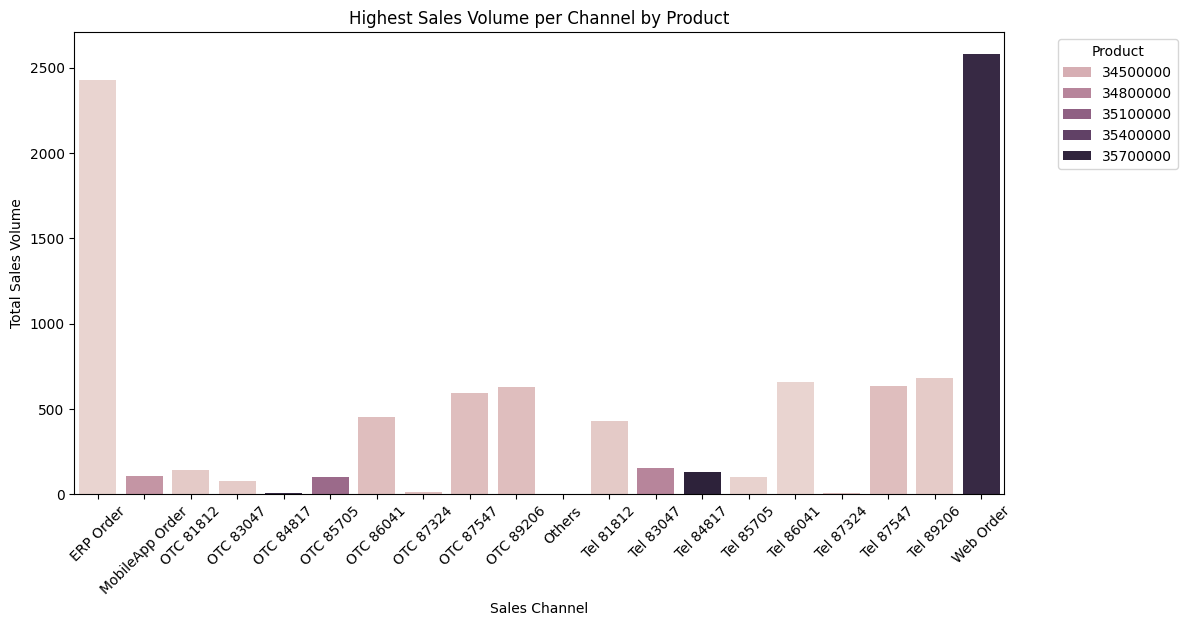

In [77]:
# Group by channel and product to get total sales volume for each
channel_product_sales = df_ut.groupby(['channel', 'articlenr'])['volume'].sum().reset_index()

# Identify the highest sales volume product per channel
top_sales_per_channel = channel_product_sales.loc[channel_product_sales.groupby('channel')['volume'].idxmax()]

# Plotting the highest sales volume per channel
plt.figure(figsize=(12, 6))
sns.barplot(data=top_sales_per_channel, x='channel', y='volume', hue='articlenr', dodge=False)
plt.title('Highest Sales Volume per Channel by Product')
plt.xlabel('Sales Channel')
plt.ylabel('Total Sales Volume')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


Each bar represents a different sales channel.
The height of each bar shows the sales volume of the top-performing product within that channel.

Key observations: Dominance of ERP and Web Orders:

The ERP Order and Web Order channels have the highest individual product sales volumes among all channels.
The Web Order channel, in particular, has an exceptionally high sales volume for Product 35700000, significantly higher than any other channel-product combination.
Product 34500000 is the top-selling product in the ERP Order channel, with a substantial sales volume as well.

Product 35700000 as a Top Performer:
Product 35700000 stands out as the highest-volume product within the Web Order channel. This could indicate that it’s particularly popular in online sales, suggesting a strong demand for this product through the Web Order platform.

Channel Variability:
Outside of ERP and Web orders, most other channels have comparatively lower top sales volumes, suggesting that these are less active sales channels.
OTC (Over-The-Counter) and Tel (Telephone) channels each have a few products with moderate sales volumes, but none reach the scale seen in ERP and Web channels.
For example, OTC 87547 and Tel 85705 are notable products in the OTC and Tel channels, respectively, but their volumes are much lower compared to ERP and Web.
Product Distribution Across Channels:

Some products, such as Product 34500000, appear multiple times across different channels (e.g., ERP Order, OTC 87324, and Tel 85705), indicating a versatile product with demand across various sales channels.
Other products, like Product 35700000, are channel-specific, performing exceptionally well in only one channel (Web Order).

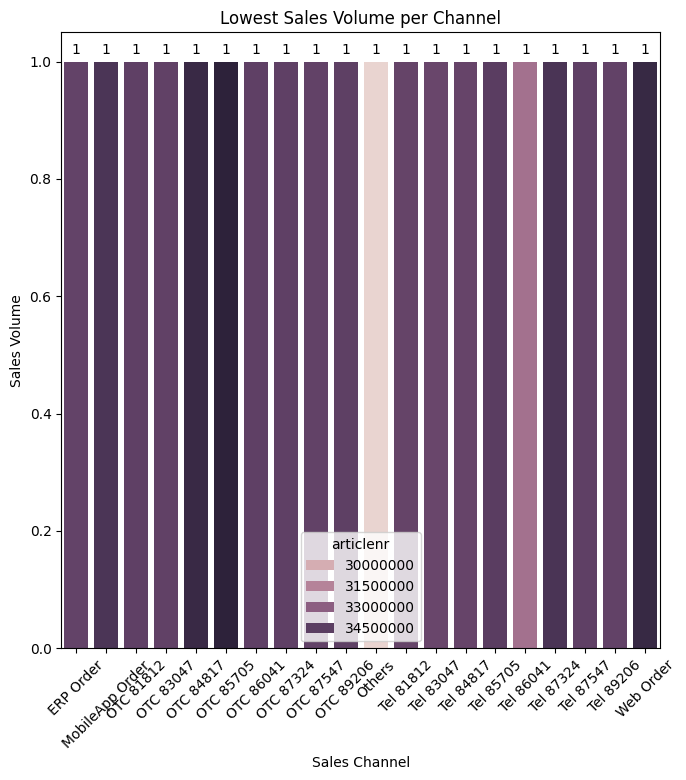

In [ ]:
# Plot settings to make visualization clearer
plt.figure(figsize=(17, 8))

# Highest Sales Volume Per Channel
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=min_sales_per_channel, x='channel', y='volume', hue='articlenr', dodge=False)
plt.title('Lowest Sales Volume per Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Sales Volume')
plt.xticks(rotation=45)

# Add data labels for highest sales volume
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

-----------------------------------------------------------------------------------------

After running the codes above, it is clear there are outliers that are needed to be removed.Therefore, I will run the same codes with the file with no outliers.

In [17]:
file_path = 'C:/Users/user/Downloads/merged_df_no_outliers.parquet'

# Load the dataframe
df_ut = pd.read_parquet('C:/Users/user/Downloads/merged_df_no_outliers.parquet')

# Verify the dataframe was loaded successfully
print(df_ut.head())


   customer  invoice invoice_date  articlenr  volume    sum1    sum2  \
0       812  1187640   2020-01-03   35620322       1  119.91  125.73   
1       812  1187640   2020-01-03   35621464       1  126.93  133.10   
2       812  1187640   2020-01-03   35626924       4    4.51    4.61   
3       812  1187640   2020-01-03   35620984       2   28.37   29.75   
4       812  1187640   2020-01-03   35620838       5   62.73   65.78   

   postcode_delivery  postcode_customer    channel  ...  volume_Outlier_IQR  \
0              81681              81681  Web Order  ...               False   
1              81681              81681  Web Order  ...               False   
2              81681              81681  Web Order  ...               False   
3              81681              81681  Web Order  ...               False   
4              81681              81681  Web Order  ...               False   

  volume_Outlier sum1_Modified_Z_Score  sum1_Outlier_Modified_Z  \
0          False         

In [18]:
df_ut.isnull().sum()

customer                     0
invoice                      0
invoice_date                 0
articlenr                    0
volume                       0
sum1                         0
sum2                         0
postcode_delivery            0
postcode_customer            0
channel                      0
ETIM                         8
statistiek_hoofdgroep        0
statistiek_subgroep          0
profit                       0
Modified_Z_Score             0
Outlier_Modified_Z           0
Outlier_IQR                  0
Outlier                      0
season                       0
volume_Modified_Z_Score      0
volume_Outlier_Modified_Z    0
volume_Outlier_IQR           0
volume_Outlier               0
sum1_Modified_Z_Score        0
sum1_Outlier_Modified_Z      0
sum1_Outlier_IQR             0
sum1_Outlier                 0
sum2_Modified_Z_Score        0
sum2_Outlier_Modified_Z      0
sum2_Outlier_IQR             0
sum2_Outlier                 0
dtype: int64

In [19]:
# Open the features file and read its metadata
df_ut = ('C:/Users/user/Downloads/merged_df_no_outliers.parquet')
features_file_metadata = pq.ParquetFile(df_ut)

# Get and print column names
column_names = features_file_metadata.schema.names
print(column_names)

# Count and print the number of columns
num_columns = len(column_names)
print(f"Number of columns: {num_columns}")

# Get and print the number of rows
num_rows = features_file_metadata.metadata.num_rows
print(f"Number of rows: {num_rows}")

['customer', 'invoice', 'invoice_date', 'articlenr', 'volume', 'sum1', 'sum2', 'postcode_delivery', 'postcode_customer', 'channel', 'ETIM', 'statistiek_hoofdgroep', 'statistiek_subgroep', 'profit', 'Modified_Z_Score', 'Outlier_Modified_Z', 'Outlier_IQR', 'Outlier', 'season', 'volume_Modified_Z_Score', 'volume_Outlier_Modified_Z', 'volume_Outlier_IQR', 'volume_Outlier', 'sum1_Modified_Z_Score', 'sum1_Outlier_Modified_Z', 'sum1_Outlier_IQR', 'sum1_Outlier', 'sum2_Modified_Z_Score', 'sum2_Outlier_Modified_Z', 'sum2_Outlier_IQR', 'sum2_Outlier']
Number of columns: 31
Number of rows: 166266


In [20]:
import pandas as pd

# Load the Parquet file
file_path = ('C:/Users/user/Downloads/merged_df_no_outliers.parquet')
df = pd.read_parquet(file_path)

# Display the first few rows of the DataFrame
print("First few rows of the transaction file:")
print(df.head())

# Count the number of duplicates in the 'articlenr' column
num_duplicates = df['articlenr'].duplicated().sum()
print(f"Number of duplicates in 'articlenr' column: {num_duplicates}")

First few rows of the transaction file:
   customer  invoice invoice_date  articlenr  volume    sum1    sum2  \
0       812  1187640   2020-01-03   35620322       1  119.91  125.73   
1       812  1187640   2020-01-03   35621464       1  126.93  133.10   
2       812  1187640   2020-01-03   35626924       4    4.51    4.61   
3       812  1187640   2020-01-03   35620984       2   28.37   29.75   
4       812  1187640   2020-01-03   35620838       5   62.73   65.78   

   postcode_delivery  postcode_customer    channel  ...  volume_Outlier_IQR  \
0              81681              81681  Web Order  ...               False   
1              81681              81681  Web Order  ...               False   
2              81681              81681  Web Order  ...               False   
3              81681              81681  Web Order  ...               False   
4              81681              81681  Web Order  ...               False   

  volume_Outlier sum1_Modified_Z_Score  sum1_Outlier

In [21]:
total_sales = df.groupby(['articlenr', 'channel'])['volume'].sum().reset_index()

In [22]:
max_sales_product = total_sales.loc[total_sales['volume'].idxmax()]
min_sales_product = total_sales.loc[total_sales['volume'].idxmin()]

In [23]:
# Columns that are not needed for the analysis
columns_to_drop = ['invoice', 'invoice_date', 'sum1', 'sum2', 'postcode_delivery', 'postcode_customer']  # Replace these with actual column names you want to drop

# Drop these columns from the DataFrame
df_cleaned = df.drop(columns=columns_to_drop)

# Verify if the columns have been dropped
print(df_cleaned.head())

   customer  articlenr  volume    channel   ETIM statistiek_hoofdgroep  \
0       812   35620322       1  Web Order  412.0                     C   
1       812   35621464       1  Web Order  598.0                     C   
2       812   35626924       4  Web Order  505.0                     C   
3       812   35620984       2  Web Order   78.0                     C   
4       812   35620838       5  Web Order  306.0                     C   

  statistiek_subgroep  profit  Modified_Z_Score  Outlier_Modified_Z  ...  \
0                  y3    5.82          0.917929               False  ...   
1                  y3    6.17          0.977095               False  ...   
2                  y3    0.10         -0.049024               False  ...   
3                  y3    1.38          0.167357               False  ...   
4                  y3    3.05          0.449667               False  ...   

   volume_Outlier_IQR  volume_Outlier sum1_Modified_Z_Score  \
0               False           Fal

In [24]:
# Ensure df_ut is loaded as a DataFrame
df_ut = pd.read_parquet('C:/Users/user/Downloads/merged_df_no_outliers.parquet')

# Group data by 'channel' and find the indices of the max and min sales volume for each channel
max_sales_per_channel = df_ut.loc[df_ut.groupby('channel')['volume'].idxmax()]
min_sales_per_channel = df_ut.loc[df_ut.groupby('channel')['volume'].idxmin()]

# Print the results
print("Products with the Highest Sales Volume per Channel:")
print(max_sales_per_channel)

print("\nProducts with the Lowest Sales Volume per Channel:")
print(min_sales_per_channel)

Products with the Highest Sales Volume per Channel:
        customer  invoice invoice_date  articlenr  volume    sum1    sum2  \
330          441  1195085   2020-01-30   34101866       7  113.74  138.30   
7328         727  1387567   2022-03-15   34680012       6   34.62  108.54   
5205        1630  1317676   2021-05-31   34284032       7   51.43   50.51   
10369       1130  1459451   2023-01-03   34287210       7   25.80   20.83   
4812        2453  1297102   2021-03-09   35648558       7   58.40  108.94   
37195       2281  1411323   2022-06-16   28473448       7   25.62   20.37   
421           73  1206525   2020-03-10   34440442       7    9.92    9.94   
107057      1464  1386840   2022-03-10   34380140       5   17.28   16.20   
306         1602  1205268   2020-03-05   34380220       7   13.85   12.99   
517         1105  1211139   2020-03-26   35616710       7   20.43   20.35   
155439      2390  1400288   2022-05-03   35585646       2   52.69   48.24   
76           317  119607

In [ ]:
df_ut = pd.read_parquet('C:/Users/user/Downloads/merged_df_no_outliers.parquet')

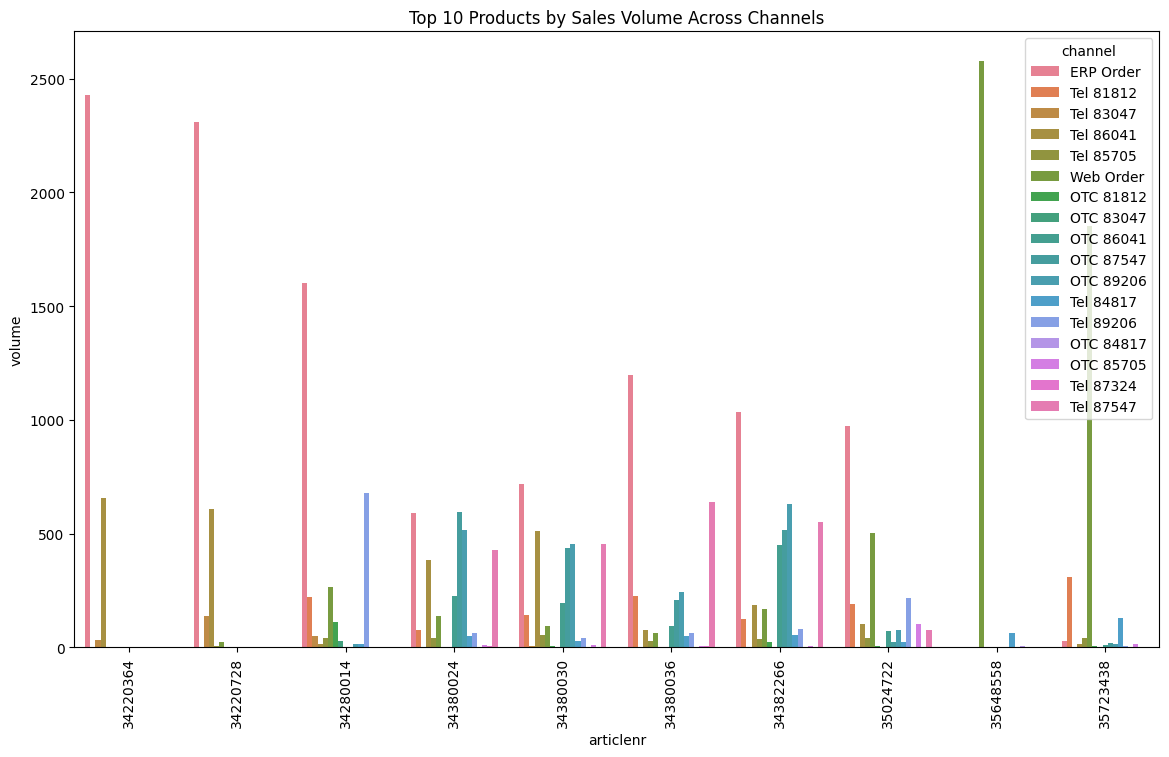

In [26]:
total_sales = df_ut.groupby(['articlenr', 'channel'])['volume'].sum().reset_index()

top_10_products = total_sales.groupby('articlenr')['volume'].sum().nlargest(10).index
filtered_data = total_sales[total_sales['articlenr'].isin(top_10_products)]

plt.figure(figsize=(14, 8))
sns.barplot(data=filtered_data, x='articlenr', y='volume', hue='channel')
plt.xticks(rotation=90)
plt.title("Top 10 Products by Sales Volume Across Channels")
plt.show()

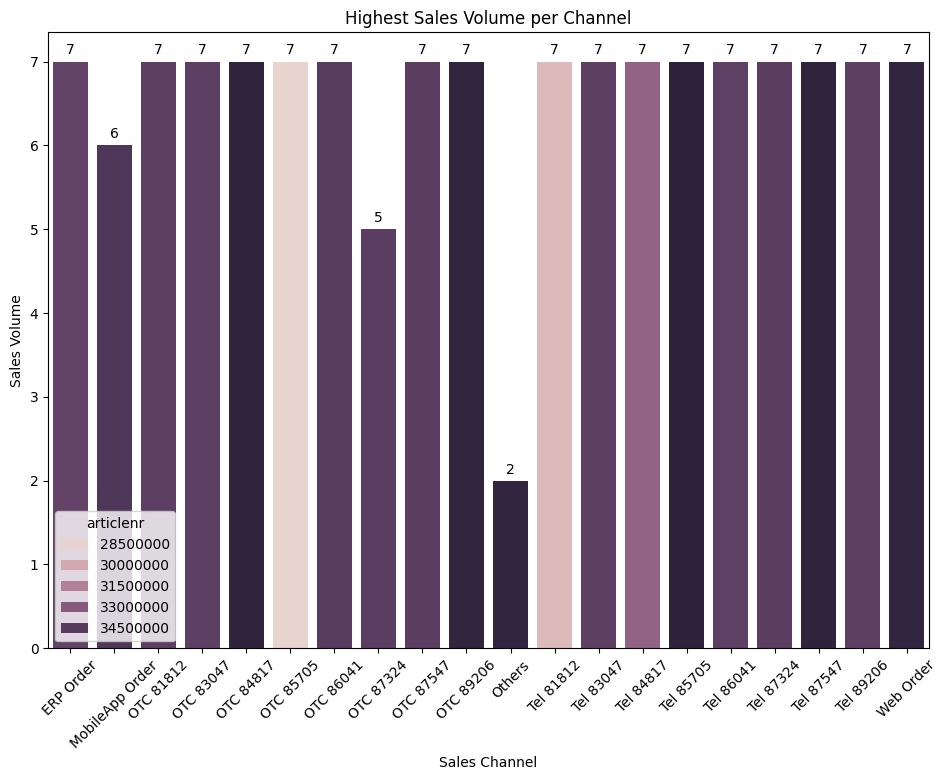

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings to make visualization clearer
plt.figure(figsize=(25, 8))

# Highest Sales Volume Per Channel
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=max_sales_per_channel, x='channel', y='volume', hue='articlenr', dodge=False)
plt.title('Highest Sales Volume per Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Sales Volume')
plt.xticks(rotation=45)

# Add data labels for highest sales volume
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

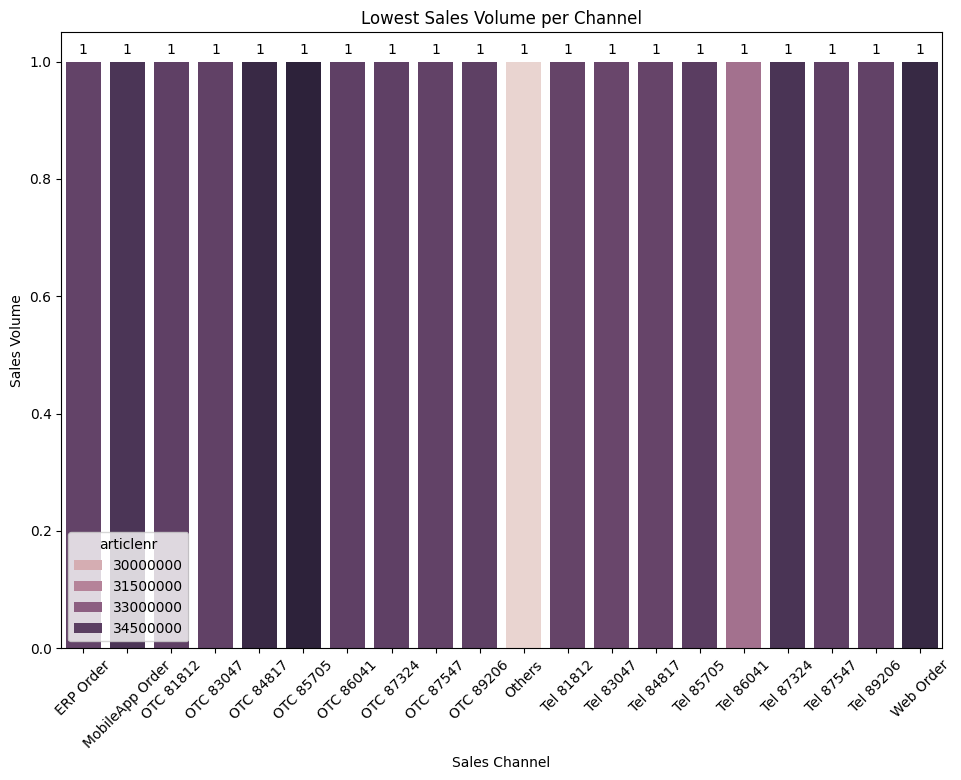

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings to make visualization clearer
plt.figure(figsize=(25, 8))

# Highest Sales Volume Per Channel
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=min_sales_per_channel, x='channel', y='volume', hue='articlenr', dodge=False)
plt.title('Lowest Sales Volume per Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Sales Volume')
plt.xticks(rotation=45)

# Add data labels for highest sales volume
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

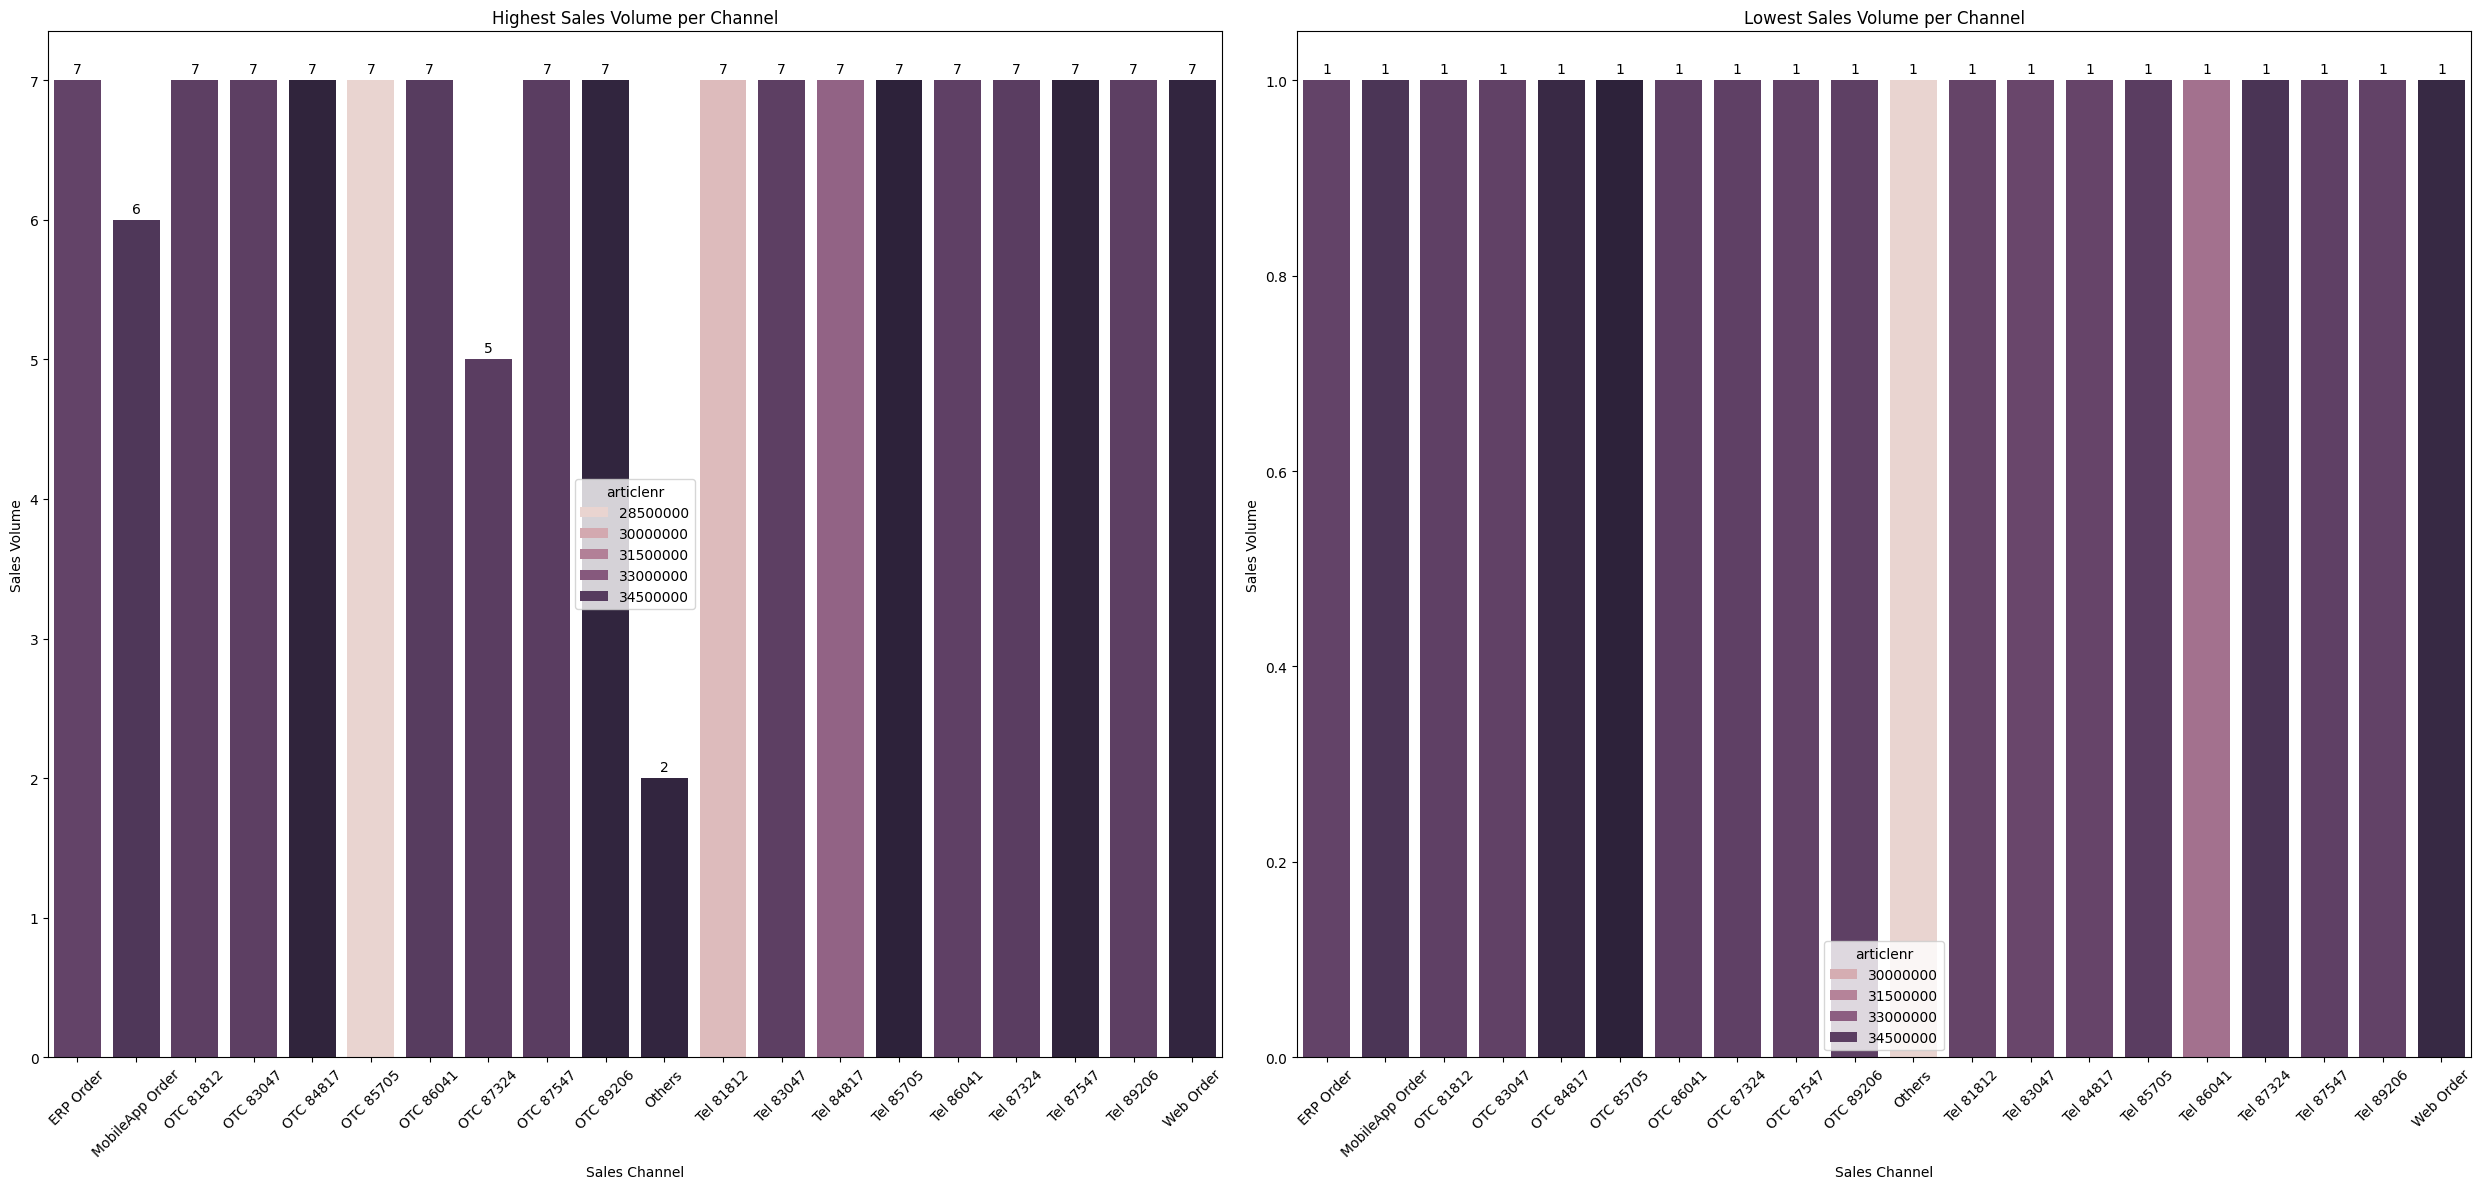

In [29]:
# Create a figure for side-by-side comparison
plt.figure(figsize=(25, 12))

# Highest Sales Volume per Channel
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=max_sales_per_channel, x='channel', y='volume', hue='articlenr', dodge=False)
plt.title('Highest Sales Volume per Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Sales Volume')
plt.xticks(rotation=45)

# Add data labels for highest sales volume
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

# Lowest Sales Volume per Channel
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=min_sales_per_channel, x='channel', y='volume', hue='articlenr', dodge=False)
plt.title('Lowest Sales Volume per Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Sales Volume')
plt.xticks(rotation=45)

# Add data labels for lowest sales volume
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

plt.tight_layout()
plt.show()


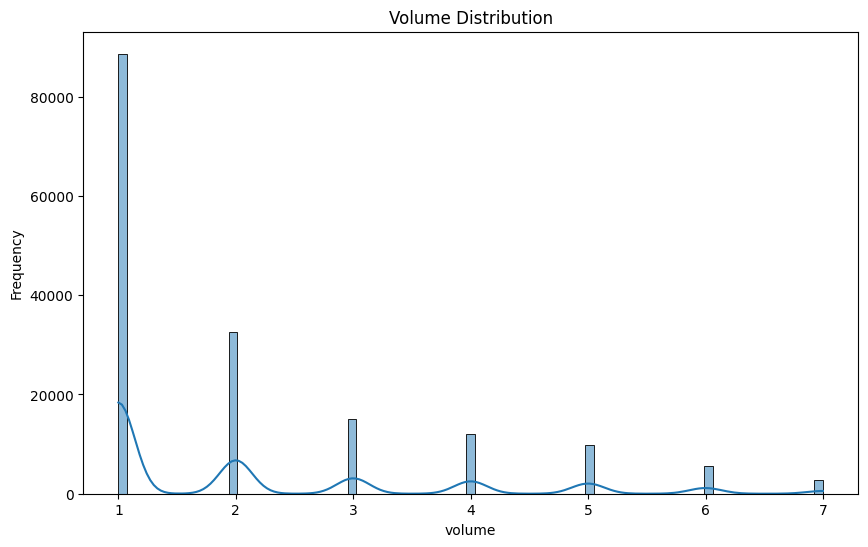

In [30]:
def plot_distribution(dataframe, column, title):
	plt.figure(figsize=(10, 6))
	sns.histplot(dataframe[column], kde=True)
	plt.title(title)
	plt.xlabel(column)
	plt.ylabel('Frequency')
	plt.show()

# Updated function call with correct column name
plot_distribution(df_ut, 'volume', 'Volume Distribution')



The histogram shows that the majority of values in the volume column are concentrated at a particular level, with a high frequency for the value 1 and progressively lower frequencies for values up to 7.

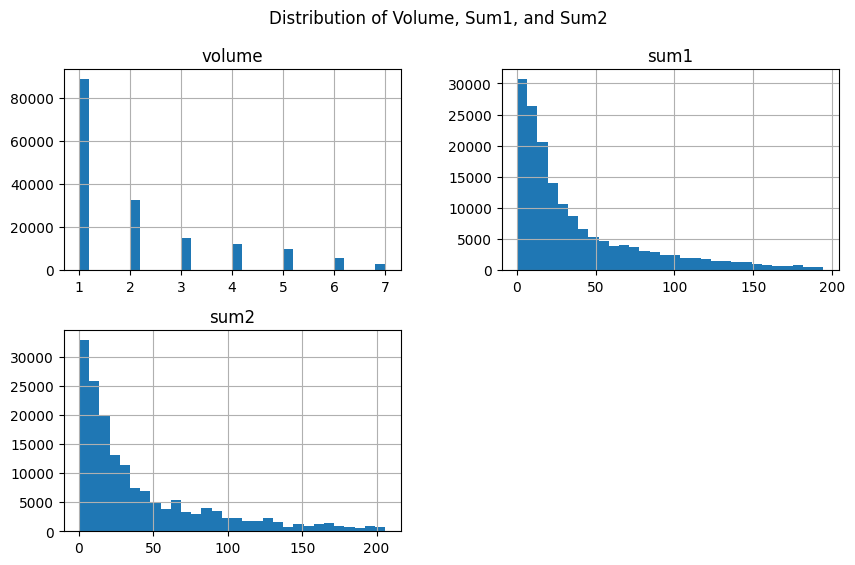

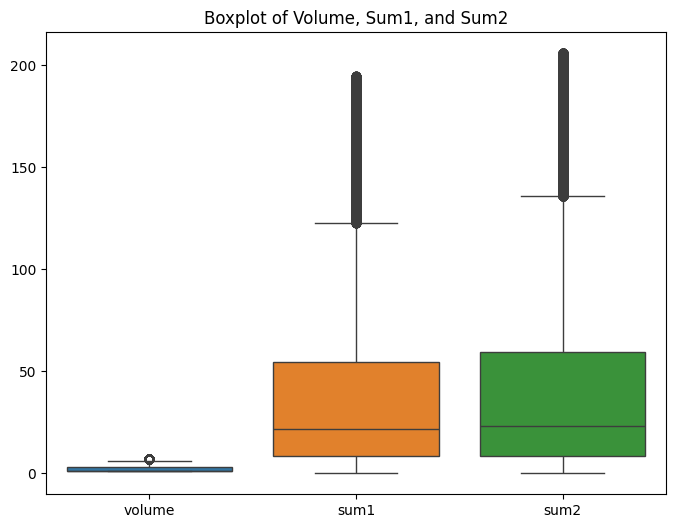

In [33]:
# Histogram of 'volume', 'sum1', and 'sum2'
df[['volume', 'sum1', 'sum2']].hist(bins=30, figsize=(10, 6))
plt.suptitle("Distribution of Volume, Sum1, and Sum2")
plt.show()

# Boxplot to check for outliers in 'volume', 'sum1', and 'sum2'
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[['volume', 'sum1', 'sum2']])
plt.title("Boxplot of Volume, Sum1, and Sum2")
plt.show()


The volume distribution is extremely compact compared to sum1 and sum2, with a few minor outliers visible above the main range.
This indicates that most volume values are tightly clustered around low values, with a very small range for typical values.
Both sum1 and sum2 have much larger ranges compared to volume.
These variables also have outliers extending far beyond the upper limit of the interquartile range (IQR), which suggests the presence of a substantial number of high-value observations.
The similarity in their distributions is consistent with the high correlation between sum1 and sum2 observed earlier, suggesting they may be measuring related aspects.
Both sum1 and sum2 are right-skewed with many low values and a few very high values (outliers), indicating that while most values are low, there are some cases of exceptionally high spending or transaction amounts.
volume is heavily right-skewed, with a much more concentrated range, indicating most values are at the low end.
Implications:
The skewness and outliers in sum1 and sum2 suggest that further analysis might benefit from handling these outliers separately, as they could disproportionately influence results in statistical modeling or clustering.
Given that volume is much lower in range and more concentrated, it may represent a fundamentally different aspect of customer behavior than sum1 and sum2.

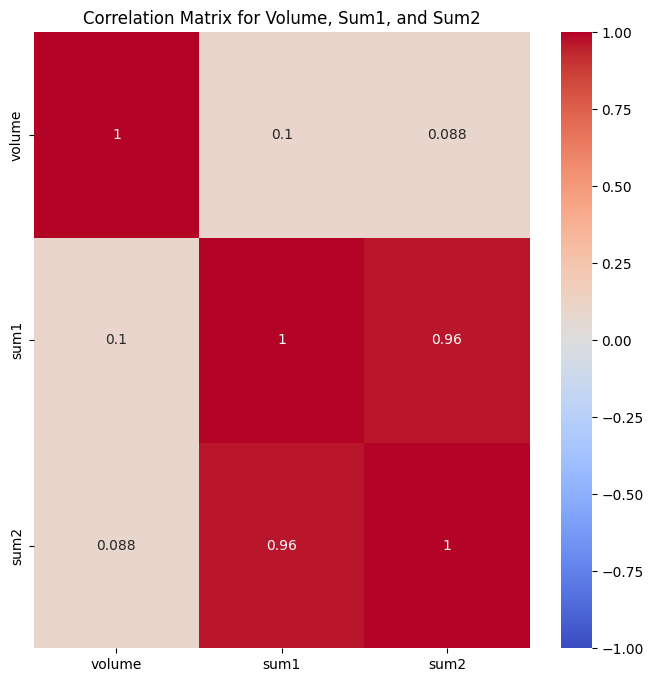

In [34]:
# Correlation heatmap for numeric columns
plt.figure(figsize=(8, 8))
sns.heatmap(df[['volume', 'sum1', 'sum2']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix for Volume, Sum1, and Sum2")
plt.show()


Correlation values:

Each cell represents the correlation coefficient between two variables, ranging from -1 to 1.
A correlation of 1 or -1 implies a perfect linear relationship, while 0 implies no linear relationship.
Positive values (closer to 1) indicate that as one variable increases, the other tends to increase as well.
Negative values (closer to -1) indicate that as one variable increases, the other tends to decrease.
Interpretations for Specific Pairs:

sum1 and sum2 (Correlation = 0.96): There is a very high positive correlation between sum1 and sum2. This means that these two variables tend to move in the same direction and are closely related. It could indicate that these two metrics are either measuring similar aspects or are influenced by similar factors.
volume and sum1 (Correlation = 0.10): There is a low positive correlation between volume and sum1, which suggests a weak association. This implies that changes in volume do not strongly relate to changes in sum1.
volume and sum2 (Correlation = 0.088): Similarly, volume and sum2 also have a weak positive correlation, indicating little to no relationship.
Implications:

The strong correlation between sum1 and sum2 might mean that including both in certain analyses could add redundancy, as they may provide similar information.
The weak correlations between volume and the sum variables suggest that volume might represent a different aspect of behavior or measurement compared to sum1 and sum2.


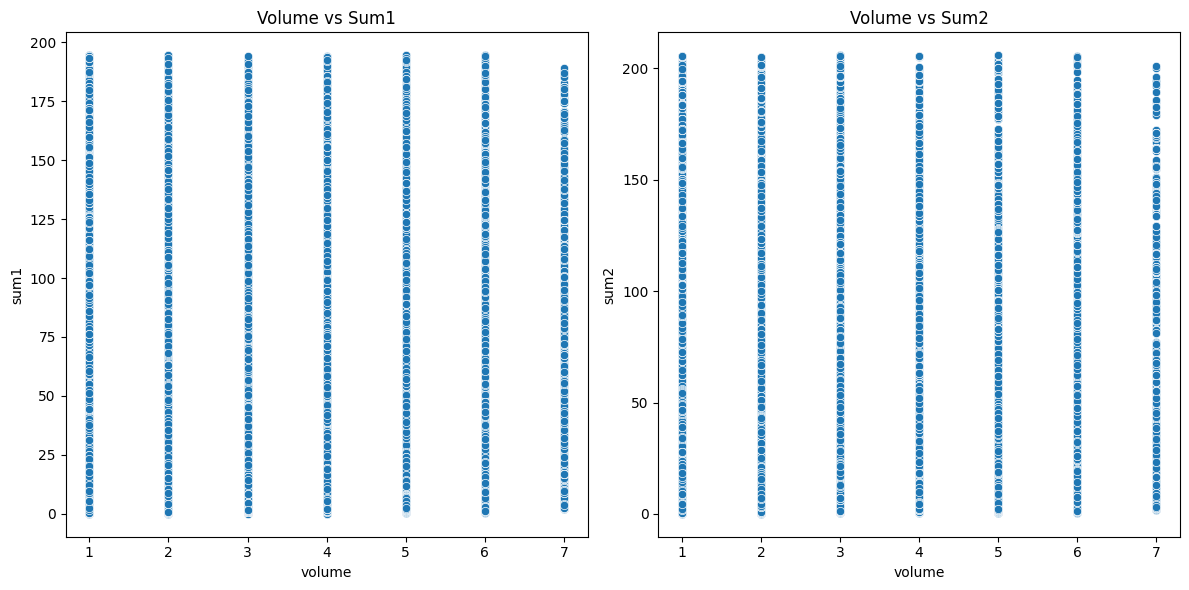

In [35]:
# Scatter plots to show relationships between volume, sum1, and sum2
plt.figure(figsize=(12, 6))

# Volume vs Sum1
plt.subplot(1, 2, 1)
sns.scatterplot(x='volume', y='sum1', data=df)
plt.title("Volume vs Sum1")

# Volume vs Sum2
plt.subplot(1, 2, 2)
sns.scatterplot(x='volume', y='sum2', data=df)
plt.title("Volume vs Sum2")

plt.tight_layout()
plt.show()

There does not appear to be a strong linear relationship between volume and sum1 or volume and sum2.
For each volume level, sum1 and sum2 span a broad range of values, from low to high. This spread suggests that changes in volume do not consistently correspond with changes in sum1 or sum2.
Weak Relationship: The plots suggest that volume does not have a strong predictive or explanatory relationship with sum1 and sum2. This aligns with the low correlation values we observed previously, reinforcing the idea that these metrics capture different aspects of customer behavior.
High Variability: The high variability in sum1 and sum2 for each volume level might indicate that other factors (e.g., customer segment, season, channel) could be influencing sum1 and sum2 more strongly than volume does. 
There is a clear weak Relationship: The plots suggest that volume does not have a strong predictive or explanatory relationship with sum1 and sum2. This aligns with the low correlation values we observed previously, reinforcing the idea that these metrics capture different aspects of customer behavior.
High Variability: The high variability in sum1 and sum2 for each volume level might indicate that other factors (e.g., customer segment, season, channel) could be influencing sum1 and sum2 more strongly than volume does.

<module 'matplotlib.pyplot' from 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python312\\site-packages\\matplotlib\\pyplot.py'>

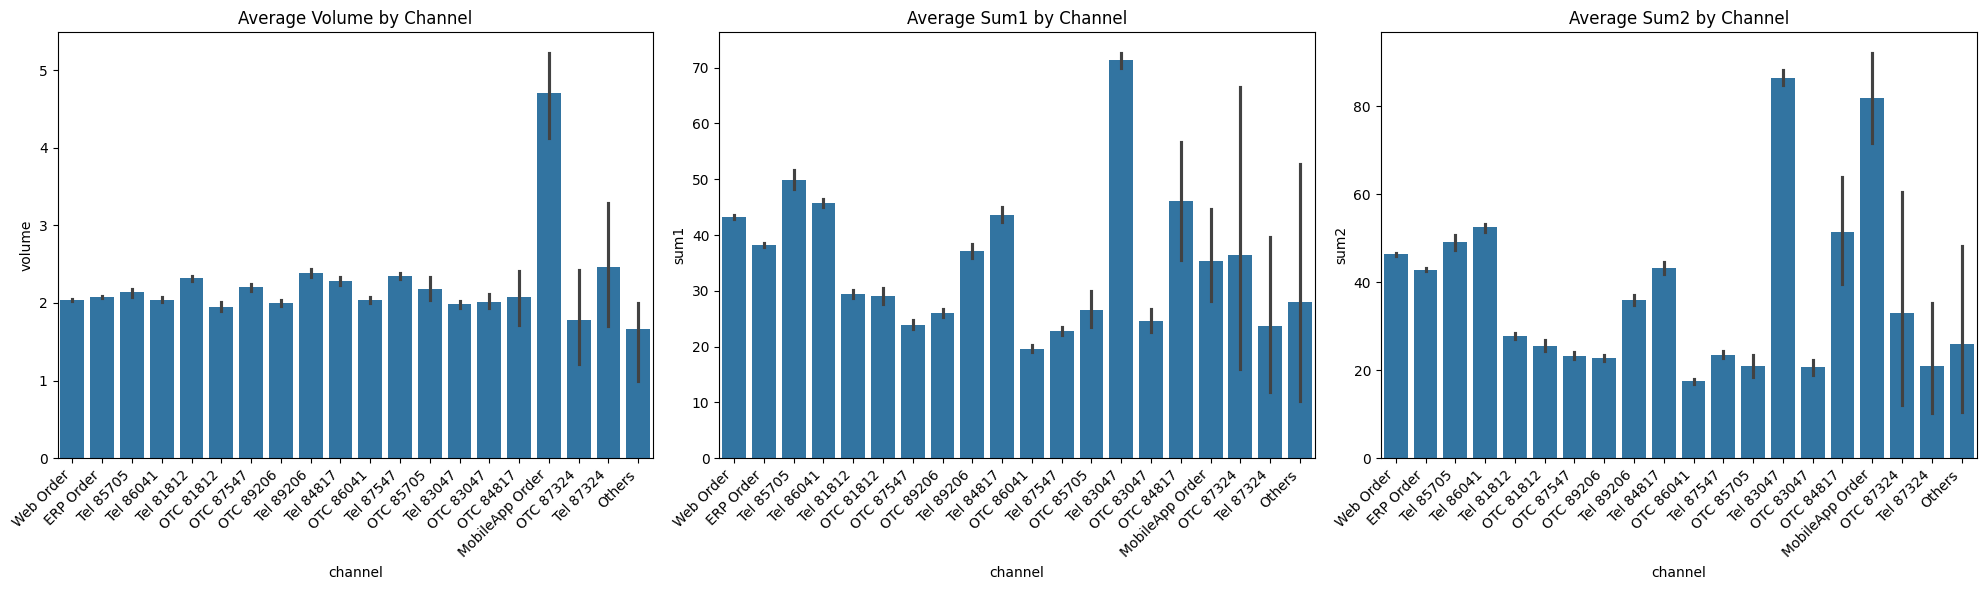

In [36]:
# Increase figure size and adjust the rotation of x-axis labels
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6))

# Average Volume by Channel
plt.subplot(1, 3, 1)
sns.barplot(x='channel', y='volume', data=df, estimator='mean')
plt.title("Average Volume by Channel")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

# Average Sum1 by Channel
plt.subplot(1, 3, 2)
sns.barplot(x='channel', y='sum1', data=df, estimator='mean')
plt.title("Average Sum1 by Channel")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

# Average Sum2 by Channel
plt.subplot(1, 3, 3)
sns.barplot(x='channel', y='sum2', data=df, estimator='mean')
plt.title("Average Sum2 by Channel")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

plt.tight_layout()
plt


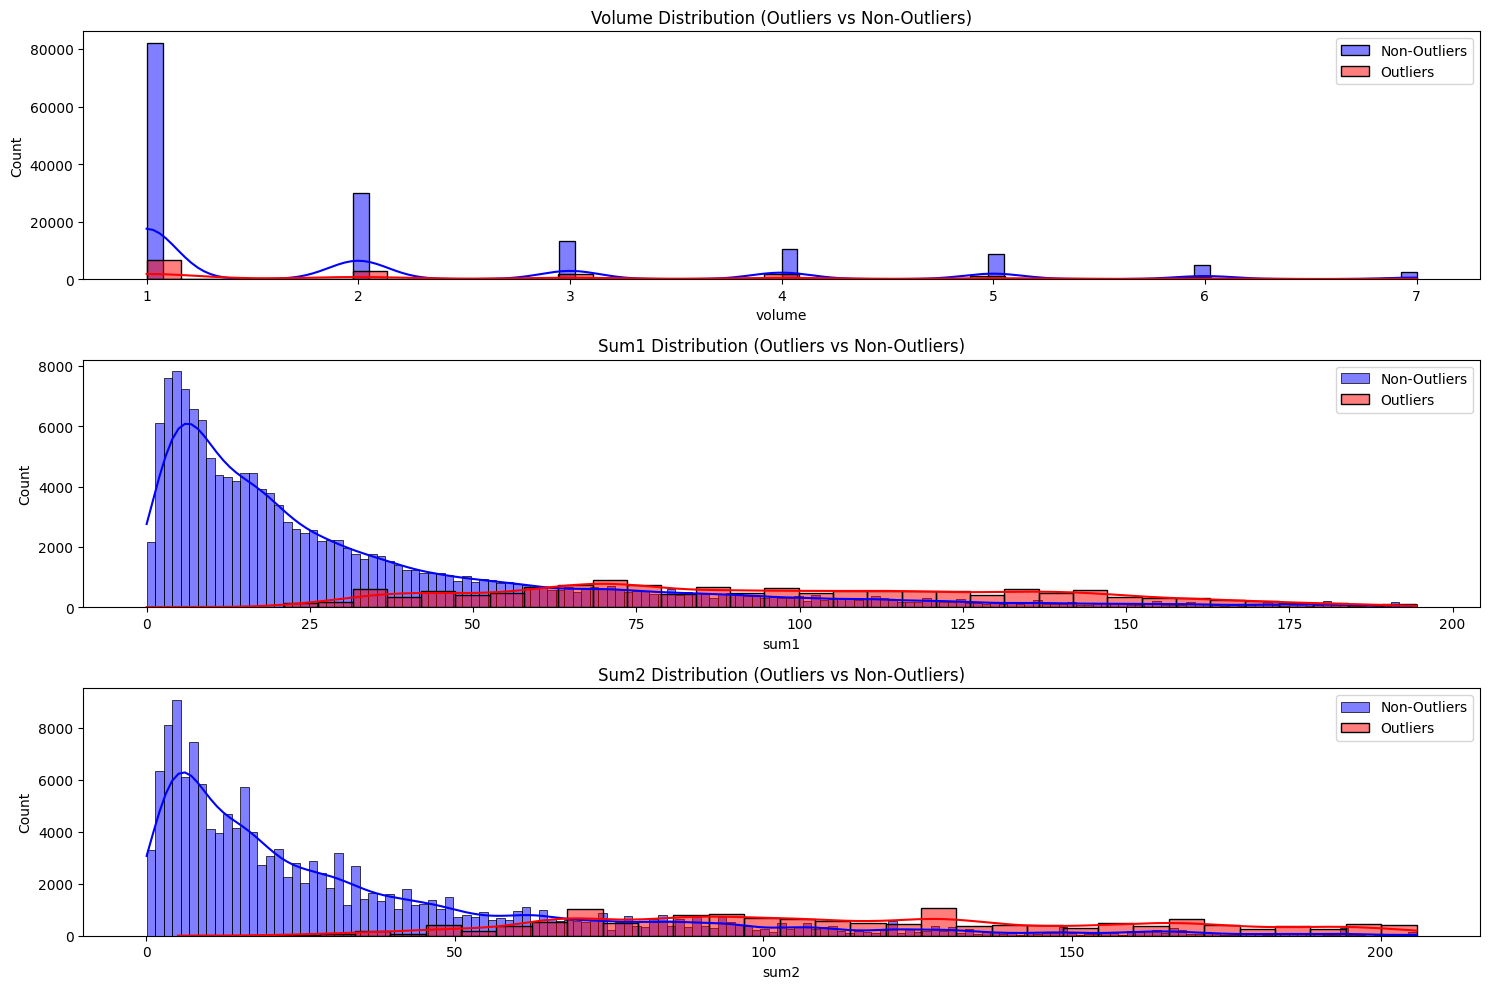

In [37]:
# Separate outliers and non-outliers
outliers = df[df['Outlier_Modified_Z'] == True]
non_outliers = df[df['Outlier_Modified_Z'] == False]

# Plot Volume, Sum1, Sum2 for Outliers vs Non-Outliers
plt.figure(figsize=(15, 10))

# Volume distribution comparison
plt.subplot(3, 1, 1)
sns.histplot(non_outliers['volume'], color="blue", label="Non-Outliers", kde=True)
sns.histplot(outliers['volume'], color="red", label="Outliers", kde=True)
plt.title("Volume Distribution (Outliers vs Non-Outliers)")
plt.legend()

# Sum1 distribution comparison
plt.subplot(3, 1, 2)
sns.histplot(non_outliers['sum1'], color="blue", label="Non-Outliers", kde=True)
sns.histplot(outliers['sum1'], color="red", label="Outliers", kde=True)
plt.title("Sum1 Distribution (Outliers vs Non-Outliers)")
plt.legend()

# Sum2 distribution comparison
plt.subplot(3, 1, 3)
sns.histplot(non_outliers['sum2'], color="blue", label="Non-Outliers", kde=True)
sns.histplot(outliers['sum2'], color="red", label="Outliers", kde=True)
plt.title("Sum2 Distribution (Outliers vs Non-Outliers)")
plt.legend()

plt.tight_layout()
plt.show()


1. Volume Distribution (Top Plot)
Non-Outliers (blue bars) dominate the volume distribution and are highly concentrated at the low end, with the majority of counts occurring at volume values of 1 and 2.
Outliers (red bars) are sparsely distributed across the volume levels, but they are present in small amounts at each level. The red overlay is faint because the count of outliers in volume is very low compared to non-outliers.
Observation: The distribution of volume is heavily skewed towards lower values, and outliers appear to have minimal impact on the overall shape of the distribution.

2. Sum1 Distribution (Middle Plot)
Non-Outliers (blue bars) follow a right-skewed distribution, with most values concentrated between 0 and 25. The frequency of values drops significantly as sum1 increases, but the tail extends up to around 200.
Outliers (red bars) are spread out more toward the higher end of sum1, especially beyond 50. Outliers become increasingly prominent in the distribution as sum1 values rise, indicating that most outliers in sum1 represent high values.
Observation: Outliers have a more noticeable impact on sum1, particularly at the higher end of the distribution. This suggests that some transactions or spending amounts classified as outliers have substantially higher values for sum1.

3. Sum2 Distribution (Bottom Plot)
Non-Outliers (blue bars) display a similar right-skewed distribution to sum1, with most values concentrated at lower values (0–25) and a long tail extending to around 200.
Outliers (red bars) show a pattern similar to sum1, with more prominence at higher values, especially beyond 50. The outliers become more common as sum2 values increase, highlighting that high values in sum2 tend to be classified as outliers.
Observation: Like sum1, sum2 also has a considerable number of high-value outliers, reinforcing that larger transaction amounts or spending patterns tend to fall into the outlier category.

In [38]:
# Isolate rows where sum1 and/or sum2 are marked as outliers
sum1_outliers = df[df['sum1_Outlier_Modified_Z'] == True]
sum2_outliers = df[df['sum2_Outlier_Modified_Z'] == True]

# Combine both sets of outliers to analyze high-spending transactions in either sum1 or sum2
high_spending_outliers = pd.concat([sum1_outliers, sum2_outliers]).drop_duplicates()

# Check the number of high-spending outliers
print("Number of high-spending outliers:", high_spending_outliers.shape[0])


Number of high-spending outliers: 0


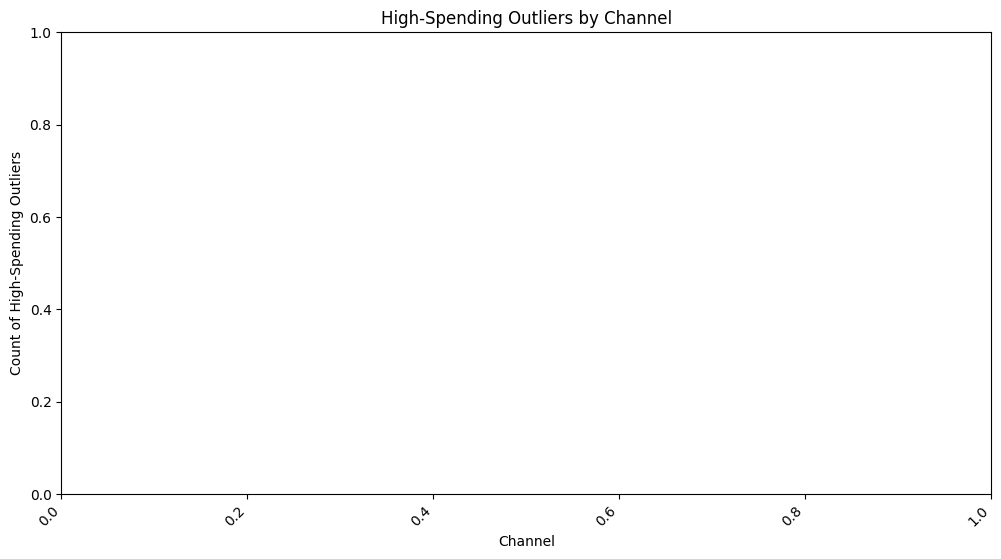

In [40]:

# Plot the distribution of high-spending outliers by channel
plt.figure(figsize=(12, 6))
sns.countplot(data=high_spending_outliers, x='channel', order=high_spending_outliers['channel'].value_counts().index)
plt.title("High-Spending Outliers by Channel")
plt.xlabel("Channel")
plt.ylabel("Count of High-Spending Outliers")
plt.xticks(rotation=45, ha='right')
plt.show()


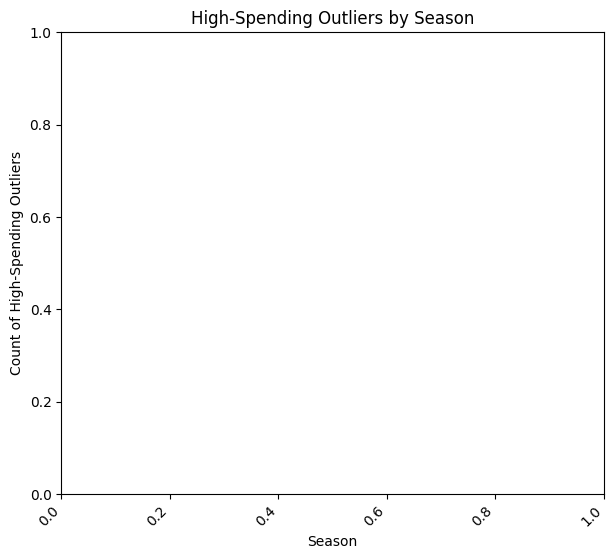

In [41]:
# Plot the distribution of high-spending outliers by season
plt.figure(figsize=(7, 6))
sns.countplot(data=high_spending_outliers, x='season', order=high_spending_outliers['season'].value_counts().index)
plt.title("High-Spending Outliers by Season")
plt.xlabel("Season")
plt.ylabel("Count of High-Spending Outliers")
plt.xticks(rotation=45, ha='right')
plt.show()


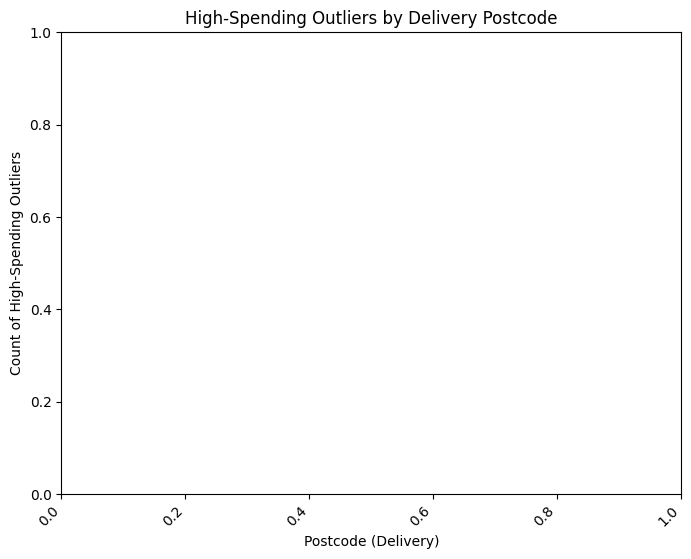

In [42]:
# Plot high-spending outliers by delivery postcode
plt.figure(figsize=(8, 6))
sns.countplot(data=high_spending_outliers, x='postcode_delivery', order=high_spending_outliers['postcode_delivery'].value_counts().index[:10])
plt.title("High-Spending Outliers by Delivery Postcode")
plt.xlabel("Postcode (Delivery)")
plt.ylabel("Count of High-Spending Outliers")
plt.xticks(rotation=45, ha='right')
plt.show()


In [43]:
# Calculate the proportion of outliers in each channel
channel_outlier_counts = high_spending_outliers['channel'].value_counts()
channel_total_counts = df['channel'].value_counts()
channel_outlier_proportion = (channel_outlier_counts / channel_total_counts) * 100
print("Proportion of high-spending outliers by channel (%):\n", channel_outlier_proportion)


Proportion of high-spending outliers by channel (%):
 channel
ERP Order         NaN
MobileApp Order   NaN
OTC 81812         NaN
OTC 83047         NaN
OTC 84817         NaN
OTC 85705         NaN
OTC 86041         NaN
OTC 87324         NaN
OTC 87547         NaN
OTC 89206         NaN
Others            NaN
Tel 81812         NaN
Tel 83047         NaN
Tel 84817         NaN
Tel 85705         NaN
Tel 86041         NaN
Tel 87324         NaN
Tel 87547         NaN
Tel 89206         NaN
Web Order         NaN
Name: count, dtype: float64


In [44]:

# 1. Count of purchases per season for each customer
seasonal_purchase_counts = df_ut.groupby(['customer', 'season'])['invoice'].nunique().unstack(fill_value=0)
seasonal_purchase_counts.columns = [f'purchases_in_{season}' for season in seasonal_purchase_counts.columns]

# 2. Total volume per season for each customer
seasonal_volume = df_ut.groupby(['customer', 'season'])['volume'].sum().unstack(fill_value=0)
seasonal_volume.columns = [f'total_volume_in_{season}' for season in seasonal_volume.columns]

# 3. Average spending (sum1) per season for each customer
seasonal_avg_spending = df_ut.groupby(['customer', 'season'])['sum1'].mean().unstack(fill_value=0)
seasonal_avg_spending.columns = [f'avg_sum1_in_{season}' for season in seasonal_avg_spending.columns]

# Merging these features back into the main DataFrame by customer
# First, resetting the index of each to make merging easier
seasonal_purchase_counts = seasonal_purchase_counts.reset_index()
seasonal_volume = seasonal_volume.reset_index()
seasonal_avg_spending = seasonal_avg_spending.reset_index()

# Merging on 'customer' column
df_ut = df.merge(seasonal_purchase_counts, on='customer', how='left')
df_ut = df.merge(seasonal_volume, on='customer', how='left')
df_ut = df.merge(seasonal_avg_spending, on='customer', how='left')


These features will provide a seasonal perspective on customer behavior, which is especially useful for analyzing trends, planning seasonal marketing campaigns, and adjusting stock based on expected demand. 

In [46]:
# Summary statistics for seasonal columns
df_ut.describe()


,customer,invoice,invoice_date,articlenr,volume,sum1,sum2,postcode_delivery,postcode_customer,ETIM,profit,Modified_Z_Score,volume_Modified_Z_Score,sum1_Modified_Z_Score,sum2_Modified_Z_Score,avg_sum1_in_Fall,avg_sum1_in_Spring,avg_sum1_in_Summer,avg_sum1_in_Winter
count,166266.000000,1.662660e+05,166266,1.662660e+05,166266.000000,166266.000000,166266.000000,166266.000000,166266.000000,166258.000000,166266.000000,166266.000000,166266.000000,166266.000000,166266.000000,166266.000000,166266.000000,166266.000000,166266.000000
mean,1180.171833,1.381751e+06,2022-02-21 11:22:57.460214528,3.456885e+07,2.092911,38.567468,41.338939,84994.925270,84996.139553,208.128180,2.771471,0.402582,0.062669,0.021140,0.041544,38.684872,38.102652,38.975623,38.532429
min,0.000000,1.187460e+06,2020-01-02 00:00:00,2.824080e+07,1.000000,0.000000,0.060000,80000.000000,80000.000000,0.000000,-107.780000,-18.285881,-0.674500,-0.839388,-0.825019,0.000000,0.000000,0.000000,0.000000
25%,441.000000,1.278478e+06,2020-12-17 00:00:00,3.424254e+07,1.000000,8.700000,8.630000,82280.000000,82288.000000,48.000000,-1.210000,-0.270476,-0.674500,-0.645271,-0.645110,20.345339,21.217617,21.535905,22.055257
50%,812.000000,1.370971e+06,2022-01-11 00:00:00,3.439883e+07,1.000000,21.630000,23.100000,85521.000000,85521.000000,168.000000,0.250000,-0.023667,-0.674500,-0.356773,-0.341344,43.228273,38.886495,42.250917,38.039049
75%,2157.000000,1.486665e+06,2023-04-20 00:00:00,3.558674e+07,3.000000,54.320000,59.500000,85707.000000,85707.000000,311.000000,4.600000,0.711690,0.674500,0.372615,0.422796,56.286128,56.602703,55.769480,56.141900
max,2500.000000,2.579495e+06,2024-09-25 00:00:00,3.789422e+07,7.000000,194.480000,205.820000,89900.000000,89979.000000,1121.000000,174.170000,29.377095,3.372500,3.499903,3.494468,193.490000,191.860000,180.120000,191.860000
std,882.401772,1.195874e+05,NaN,1.283580e+06,1.540193,41.441620,45.259799,2323.311164,2323.224233,176.922832,12.113892,2.047825,1.038860,0.924657,0.950132,18.464251,18.436161,18.887582,18.792181


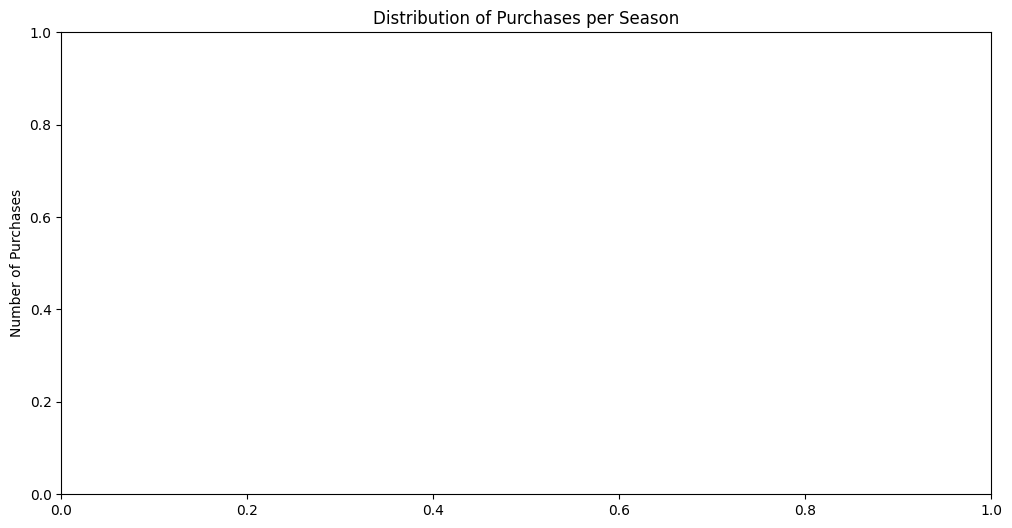

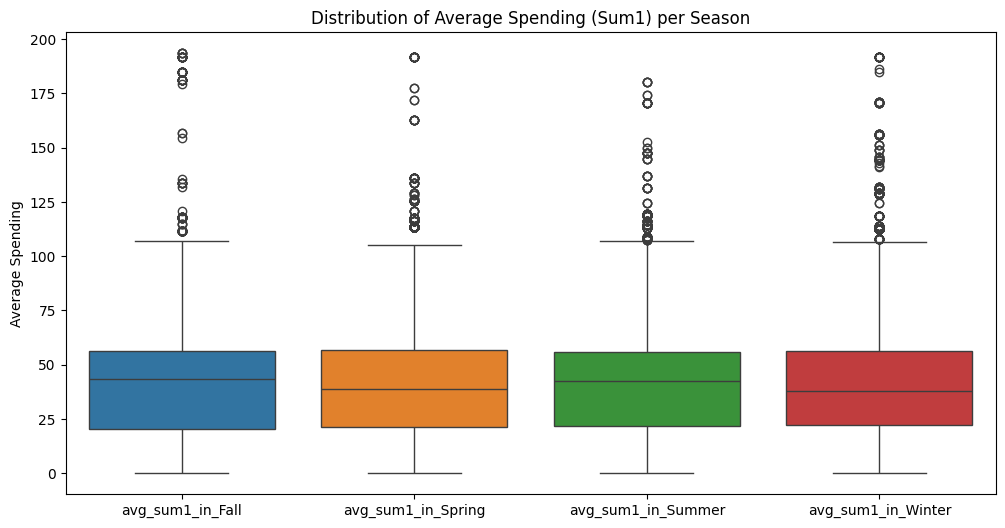

In [48]:
# Box plots for seasonal purchase counts
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_ut[[col for col in df_ut.columns if 'purchases_in_' in col]])
plt.title('Distribution of Purchases per Season')
plt.ylabel('Number of Purchases')
plt.show()
# Box plots for seasonal average spending
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_ut[[col for col in df_ut.columns if 'avg_sum1_in_' in col]])
plt.title('Distribution of Average Spending (Sum1) per Season')
plt.ylabel('Average Spending')
plt.show()

There are notable differences in the median number of purchases across seasons.
Spring has the highest median number of purchases among the seasons, suggesting this season might be the most active in terms of customer purchases.
Winter shows the lowest median purchase count, indicating it may be a low season for sales.
There is a significant outlier in Winter, where one customer has an unusually high number of purchases (around 1200), which is much higher than the rest. This might represent an anomaly or a highly active customer.
This seasonal variation suggests that promotional activities or inventory planning could be adjusted to focus more on Spring and less on Winter.
The median average spending per customer is fairly consistent across all seasons, with slight variations.
The stable spending pattern across seasons suggests that while the volume or frequency of purchases might vary, the average transaction value per customer is relatively unaffected by seasonality.

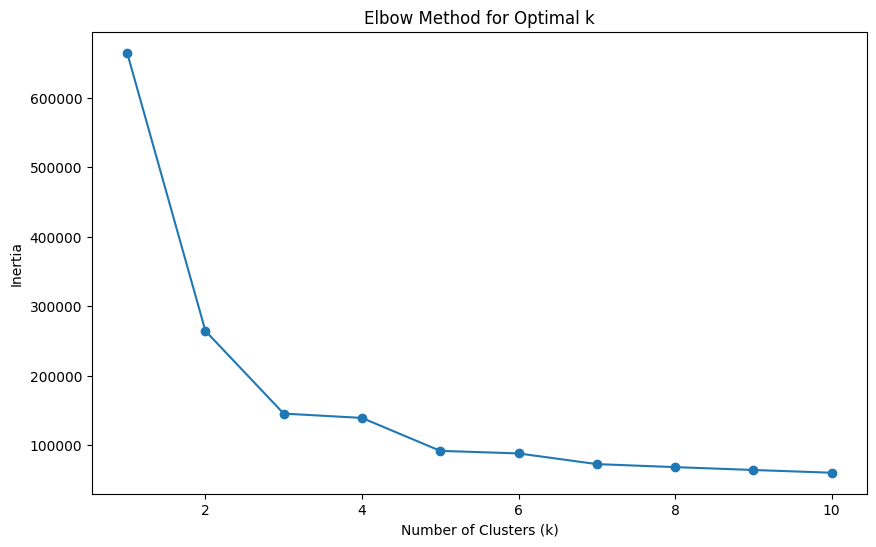

In [50]:
# Select the seasonal features for clustering
seasonal_features = df_ut[[col for col in df_ut.columns if 'purchases_in_' in col or 
                           'total_volume_in_' in col or 'avg_sum1_in_' in col]]

# Standardize the features
scaler = StandardScaler()
seasonal_features_scaled = scaler.fit_transform(seasonal_features)

# Calculate inertia for a range of cluster numbers
inertia = []
k_range = range(1, 11)  # Check clusters from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(seasonal_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [51]:
from sklearn.cluster import KMeans
import pandas as pd

# Use k = 5 based on the elbow method
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df_ut['seasonal_cluster'] = kmeans.fit_predict(seasonal_features_scaled)

# View cluster assignment
print(df_ut['seasonal_cluster'].value_counts())


seasonal_cluster
3    58940
1    58860
2    39875
4     7895
0      696
Name: count, dtype: int64


                  avg_sum1_in_Fall  avg_sum1_in_Spring  avg_sum1_in_Summer  \
seasonal_cluster                                                             
0                        26.808323           25.569100           36.133086   
1                        19.219608           20.009838           19.840002   
2                        57.356796           57.560069           56.344477   
3                        40.377146           37.442953           40.276437   
4                        77.912972           80.747927           84.453530   

                  avg_sum1_in_Winter  
seasonal_cluster                      
0                          94.495787  
1                          20.116479  
2                          56.445039  
3                          37.961765  
4                          84.685938  


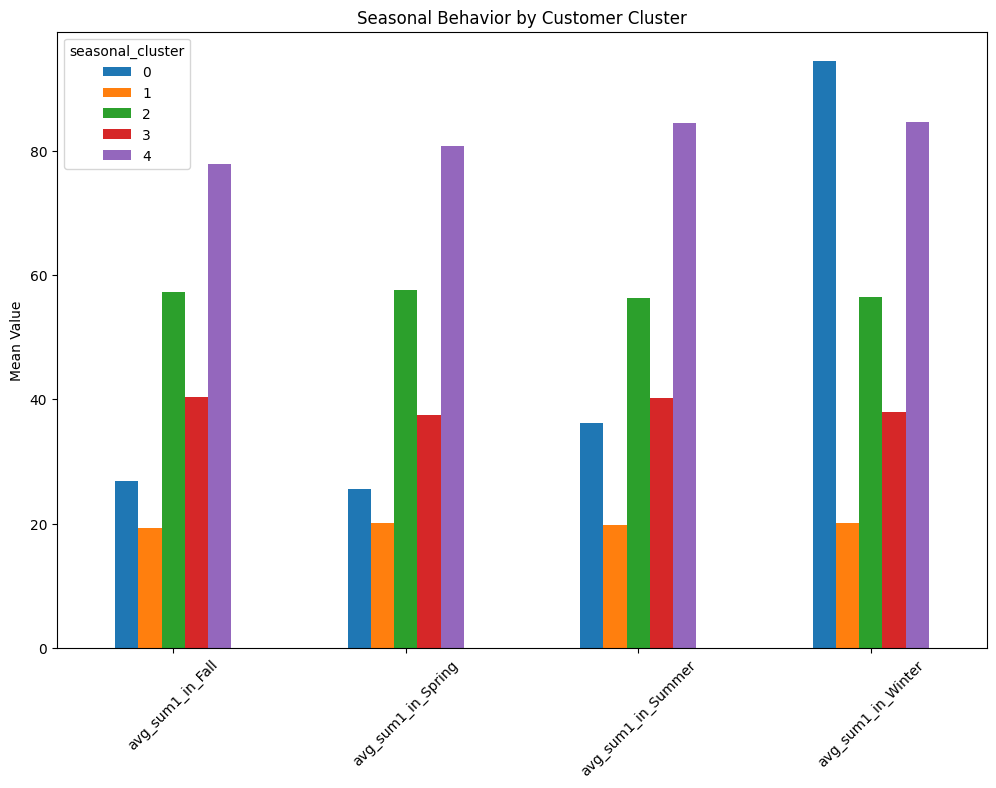

In [52]:
# Calculate the mean seasonal feature values for each cluster
cluster_means = df_ut.groupby('seasonal_cluster')[[col for col in df_ut.columns if 
                                                   'purchases_in_' in col or 
                                                   'total_volume_in_' in col or 
                                                   'avg_sum1_in_' in col]].mean()

# Display the cluster characteristics
print(cluster_means)

# Visualize the cluster characteristics
cluster_means.T.plot(kind='bar', figsize=(12, 8), title='Seasonal Behavior by Customer Cluster')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.show()


This plot shows the average seasonal values (both spending and purchases) across different customer clusters. 

Cluster 0 (Blue)
Moderate purchase counts across all seasons, with slightly higher activity in Spring and Fall.
Average spending (Sum1) per season is relatively consistent and moderate.
Interpretation: This group appears to represent moderately engaged customers who have steady purchase behavior year-round, with no particular seasonality spikes.

Cluster 1 (Orange)
Extremely high purchase counts in all seasons, especially in Spring and Winter.
Average spending per season is also higher than other clusters.
Interpretation: This cluster likely represents highly engaged customers or heavy buyers who make frequent purchases across all seasons. They are a valuable customer segment that may respond well to loyalty or retention programs, especially around peak seasons.

Cluster 2 (Green)
Moderate purchase counts, with a small peak in Spring and Fall.
Similar to Cluster 0, but with slightly higher spending levels.
Interpretation: This cluster could represent seasonally active customers who tend to increase their purchases during Spring and Fall. They might respond well to seasonal promotions.

Cluster 3 (Red)
Lower purchase counts across all seasons, with minimal seasonal fluctuation.
Average spending is also low, indicating less overall engagement.
Interpretation: This group likely consists of low-engagement or occasional customers who do not purchase frequently and have low spending levels. These customers might be harder to engage, but targeted promotions might help increase their activity.

Cluster 4 (Purple)
Very low purchase counts and low spending across all seasons.
Almost no engagement, with minimal seasonal differences.
Interpretation: This is likely the least engaged customer group, representing customers who rarely purchase. They may require stronger incentives to become active or may not be as profitable to target aggressively.

General comparison:
Cluster 1 (Heavy Buyers) stands out as the most valuable cluster, given their high purchase activity across seasons, making them key targets for loyalty programs and personalized offers.
Clusters 0 and 2 show moderate seasonal engagement, especially in Spring and Fall, suggesting that targeted seasonal promotions may boost their spending.
Clusters 3 and 4 represent lower-engagement customers, who might require different strategies to increase activity or may represent a segment where marketing investments should be carefully evaluated.

In order to completly answer the research question I will extend the analysis to focus more directly on product-level and channel-level sales volumes and connect customer segments to specific products and channels.

Sales Volume by Channel:
             channel  volume
0         ERP Order   97218
1   MobileApp Order     188
2         OTC 81812    4441
3         OTC 83047    1718
4         OTC 84817     139
5         OTC 85705     918
6         OTC 86041   11373
7         OTC 87324      25
8         OTC 87547   13157
9         OTC 89206   15313
10           Others       5
11        Tel 81812   22338
12        Tel 83047    8942
13        Tel 84817    9029
14        Tel 85705    7149
15        Tel 86041   22815
16        Tel 87324      59
17        Tel 87547   13949
18        Tel 89206    9714
19        Web Order  109490


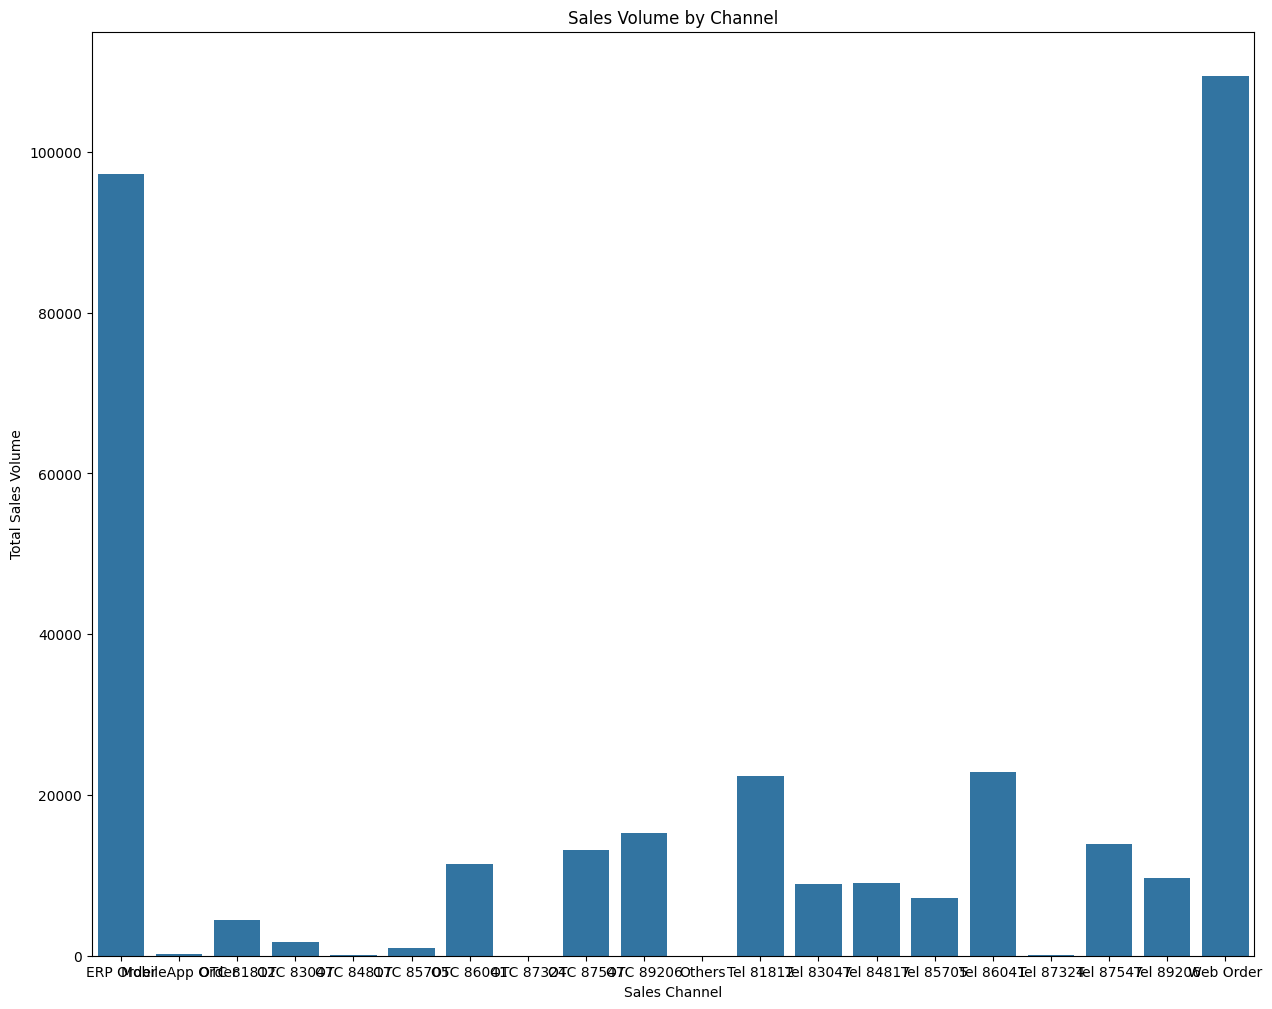

In [55]:
# Aggregating total sales volume by channel (if 'channel' exists in your dataset)
channel_sales = df_ut.groupby(['channel'])['volume'].sum().reset_index()

# Display total sales volume by channel
print("Sales Volume by Channel:\n", channel_sales)

plt.figure(figsize=(15, 12))
sns.barplot(data=channel_sales, x='channel', y='volume')
plt.title('Sales Volume by Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Total Sales Volume')
plt.show()


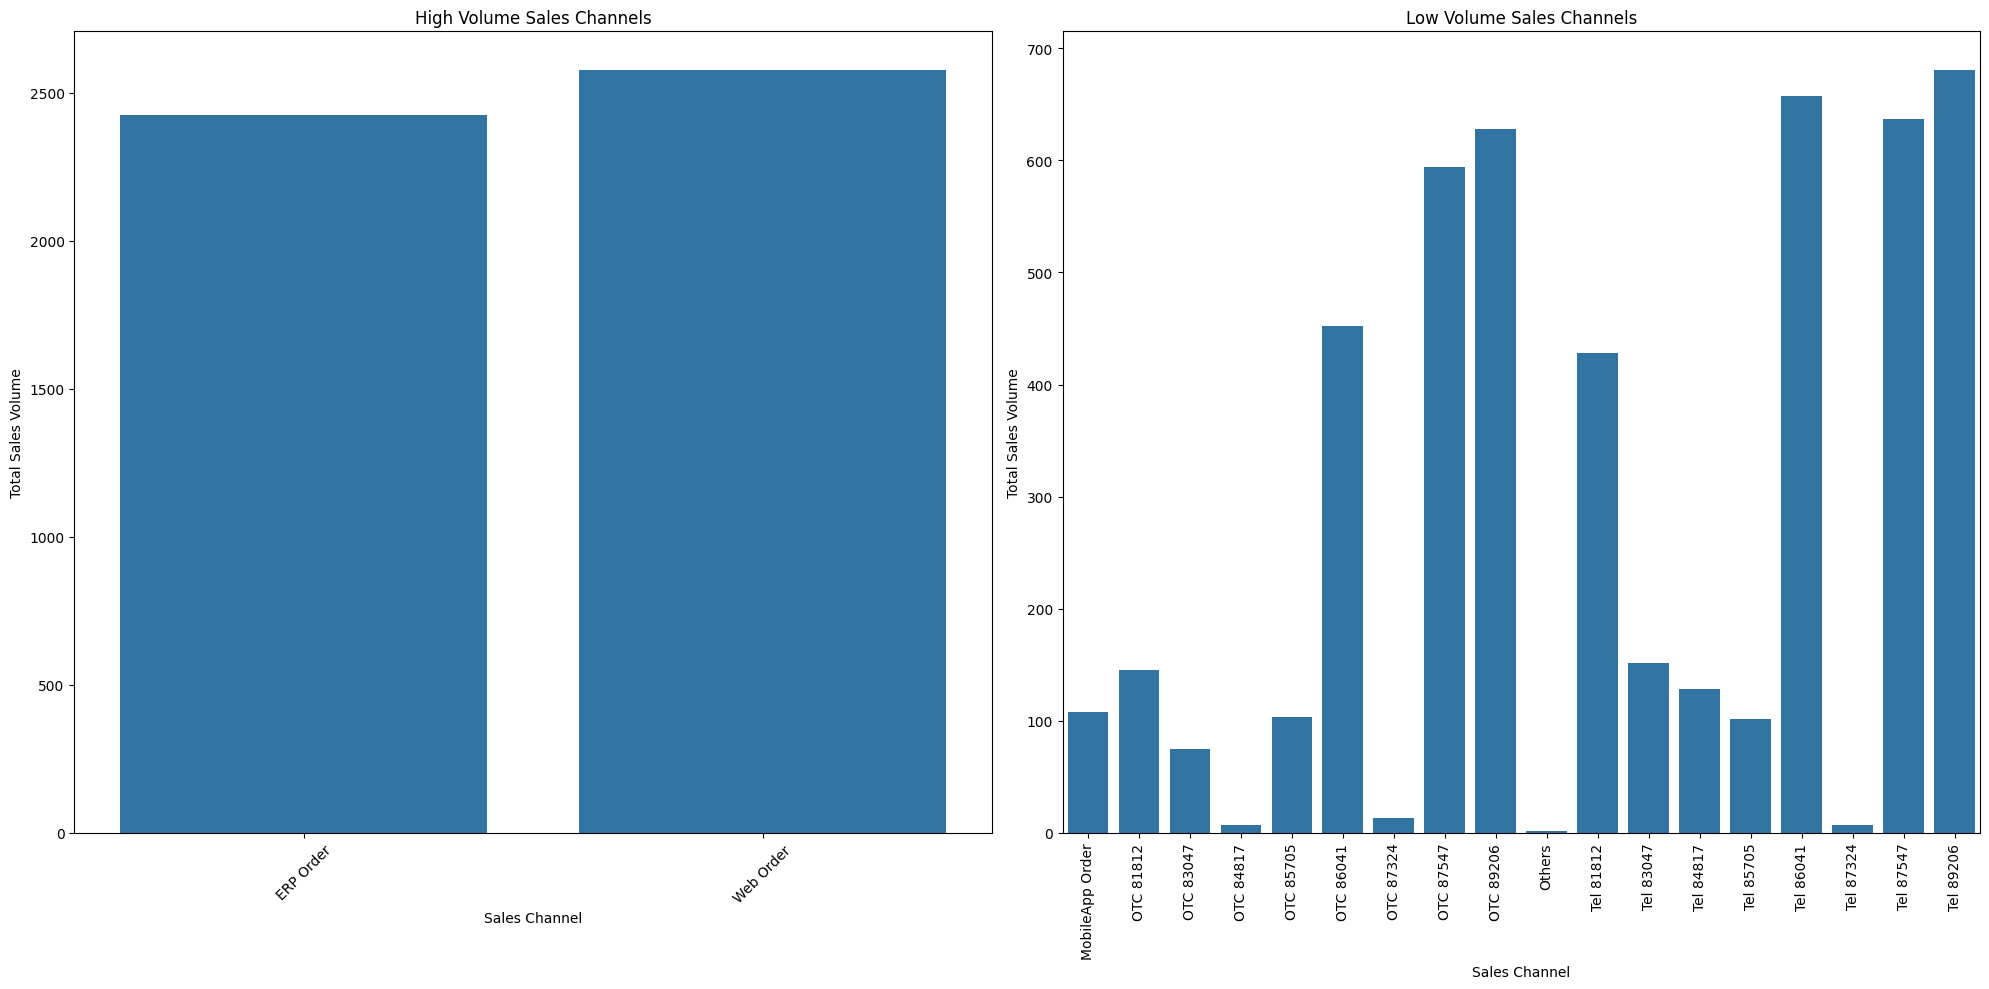

In [60]:

# Assuming total_sales is already defined in previous cells
# Filtering total_sales to get max sales per channel
max_sales_filtered = total_sales.groupby('channel')['volume'].max().reset_index()

# Splitting data into high and low volume channels for better clarity in visualization
high_volume_channels = max_sales_filtered[max_sales_filtered['channel'].isin(['ERP Order', 'Web Order'])]
low_volume_channels = max_sales_filtered[~max_sales_filtered['channel'].isin(['ERP Order', 'Web Order'])]

# Plotting with subplots to separate high and low volume channels
plt.figure(figsize=(20, 10))

# Subplot 1: High Volume Channels
plt.subplot(1, 2, 1)
sns.barplot(data=high_volume_channels, x='channel', y='volume')
plt.title('High Volume Sales Channels')
plt.xlabel('Sales Channel')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=45)

# Subplot 2: Low Volume Channels
plt.subplot(1, 2, 2)
sns.barplot(data=low_volume_channels, x='channel', y='volume')
plt.title('Low Volume Sales Channels')
plt.xlabel('Sales Channel')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()



The original dataset contained extreme values or outliers. In particular, channels like "ERP Order" and "Web Order" had extremely high sales volumes that diminished the sales volumes of other channels.
As a result, in previous plots, these high values made it difficult to see the differences in sales among other channels, as they appeared too small. So I decided to do subplotting to have a better image of the data and be able to compare the sales of each channel more easily. Due to their very high volumes compared to other channels, they are classified as high volume channels. Their significant impact can easily mask the performance of smaller channels if visualized together
Observations after sub plotting:
(RIGHT PLOT) The highest sales volumes among the low volume channels are "OTC 87547", "Tel 87547", and "Tel 89206", all reaching around 600-700 units.
There is a noticeable variation among the low volume channels, with some, like "OTC 87324" and "Tel 86041", having significantly lower sales volumes, close to 0.
MobileApp Order has one of the lower sales volumes, indicating that customers may prefer using other channels for purchases.


Top Products by Channel:
        articlenr    channel  volume
15428   35648558  Web Order    2579
4919    34220364  ERP Order    2427
5007    34220728  ERP Order    2310
16461   35723438  Web Order    1854
6444    34296812  ERP Order    1661
...          ...        ...     ...
12651   35558764  OTC 87324       2
13226   35585646     Others       2
13294   35586090     Others       2
7732    34382316  OTC 87324       1
476     28580002     Others       1

[98 rows x 3 columns]
Bottom Products by Channel:
        articlenr    channel  volume
4410    34157918  Tel 84817       1
4408    34157918  OTC 86041       1
4406    34157258  Tel 86041       1
4403    34153444  Tel 86041       1
4433    34161926  Tel 81812       1
...          ...        ...     ...
7732    34382316  OTC 87324       1
7175    34380192  OTC 87324       1
7211    34380214  OTC 87324       1
13226   35585646     Others       2
13294   35586090     Others       2

[98 rows x 3 columns]


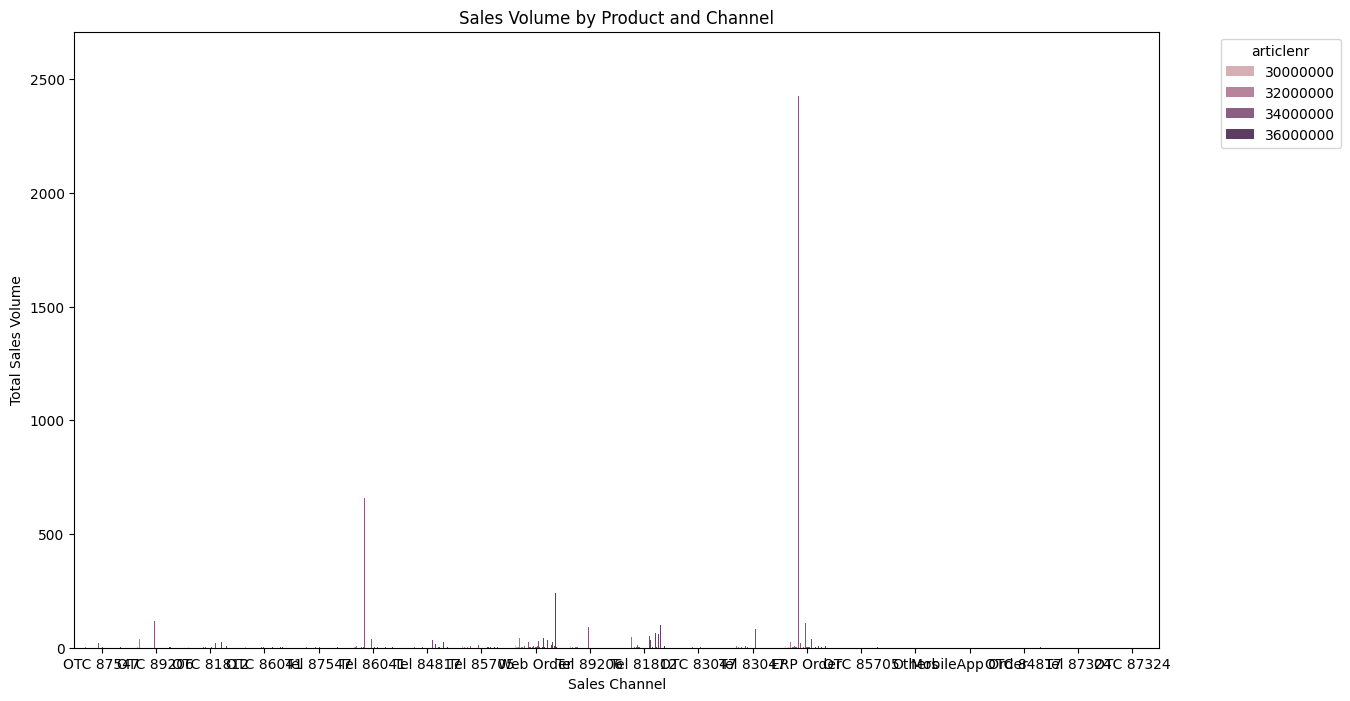

In [61]:
# Aggregating total sales volume by product and channel
product_channel_sales = df_ut.groupby(['articlenr', 'channel'])['volume'].sum().reset_index()

# Identify top and bottom products by channel
top_products_by_channel = product_channel_sales.sort_values(by='volume', ascending=False).groupby('channel').head(5)
bottom_products_by_channel = product_channel_sales.sort_values(by='volume', ascending=True).groupby('channel').head(5)

print("Top Products by Channel:\n", top_products_by_channel)
print("Bottom Products by Channel:\n", bottom_products_by_channel)


plt.figure(figsize=(14, 8))
sns.barplot(data=product_channel_sales, x='channel', y='volume', hue='articlenr')
plt.title('Sales Volume by Product and Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Total Sales Volume')
plt.legend(title='articlenr', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


This plot is cluttered and hard to interpret because of the large number of unique values on the x-axis (sales channels) and potentially a wide range of products. Therefore, instead of showing all products and channels at once, filter for the top and bottom products by sales volume. This will help focus on the products with the highest and lowest performance across channels.

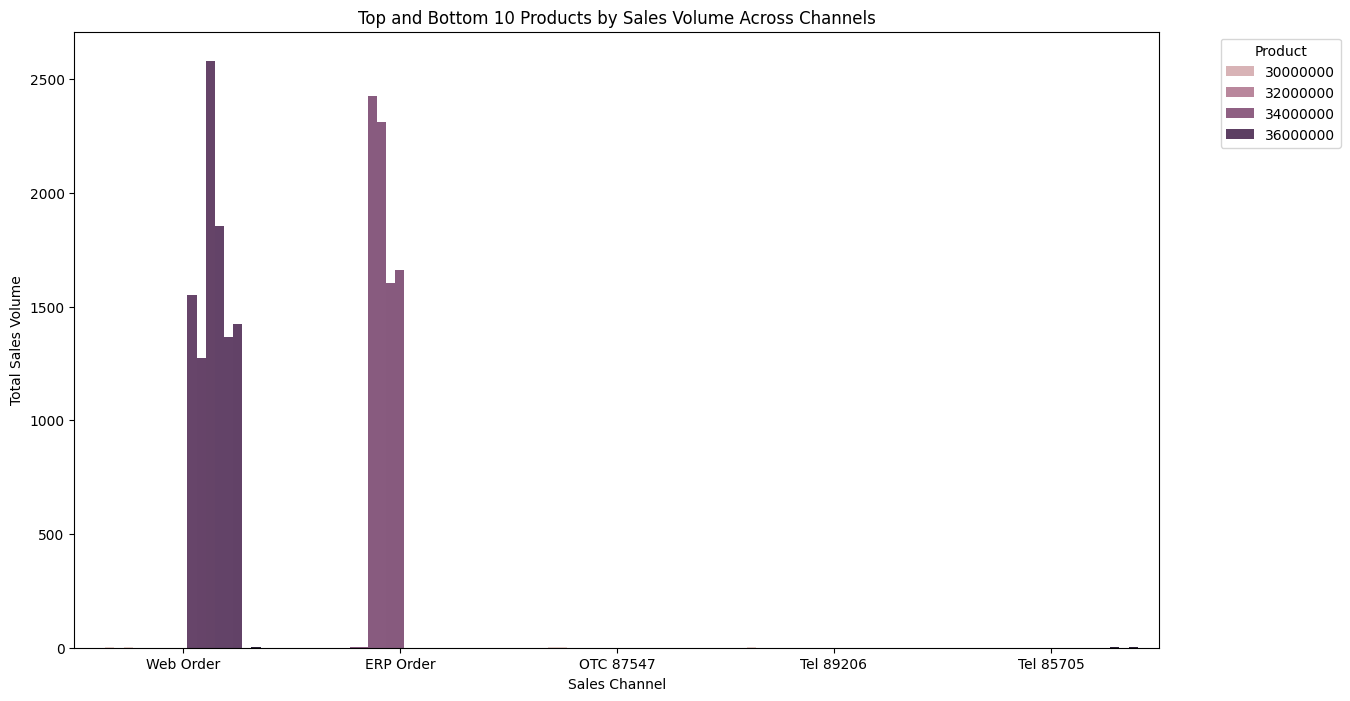

In [240]:
# Sort products by total sales volume and filter top 10 and bottom 10
top_products = product_channel_sales.sort_values(by='volume', ascending=False).head(10)
bottom_products = product_channel_sales.sort_values(by='volume', ascending=True).head(10)

# Combine top and bottom products for focused visualization
filtered_products = pd.concat([top_products, bottom_products])

plt.figure(figsize=(14, 8))
sns.barplot(data=filtered_products, x='channel', y='volume', hue='articlenr')
plt.title('Top and Bottom 10 Products by Sales Volume Across Channels')
plt.xlabel('Sales Channel')
plt.ylabel('Total Sales Volume')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


The majority of sales volume is concentrated in two channels: Web Order and ERP Order.
These two channels significantly outperform the other channels (OTC and Tel channels), indicating that Web and ERP orders are the primary drivers of sales for these top and bottom products.
Within Web Order and ERP Order channels, there are noticeable differences in sales volumes among products.
Certain products have much higher sales volume than others, suggesting that some products are particularly popular within these channels.
The OTC and Tel channels show very low sales volume for these products, indicating these channels contribute less to overall sales for these top and bottom products.
This could imply that OTC and Tel channels are either less suitable for high-volume sales or are not the primary channels for these products.

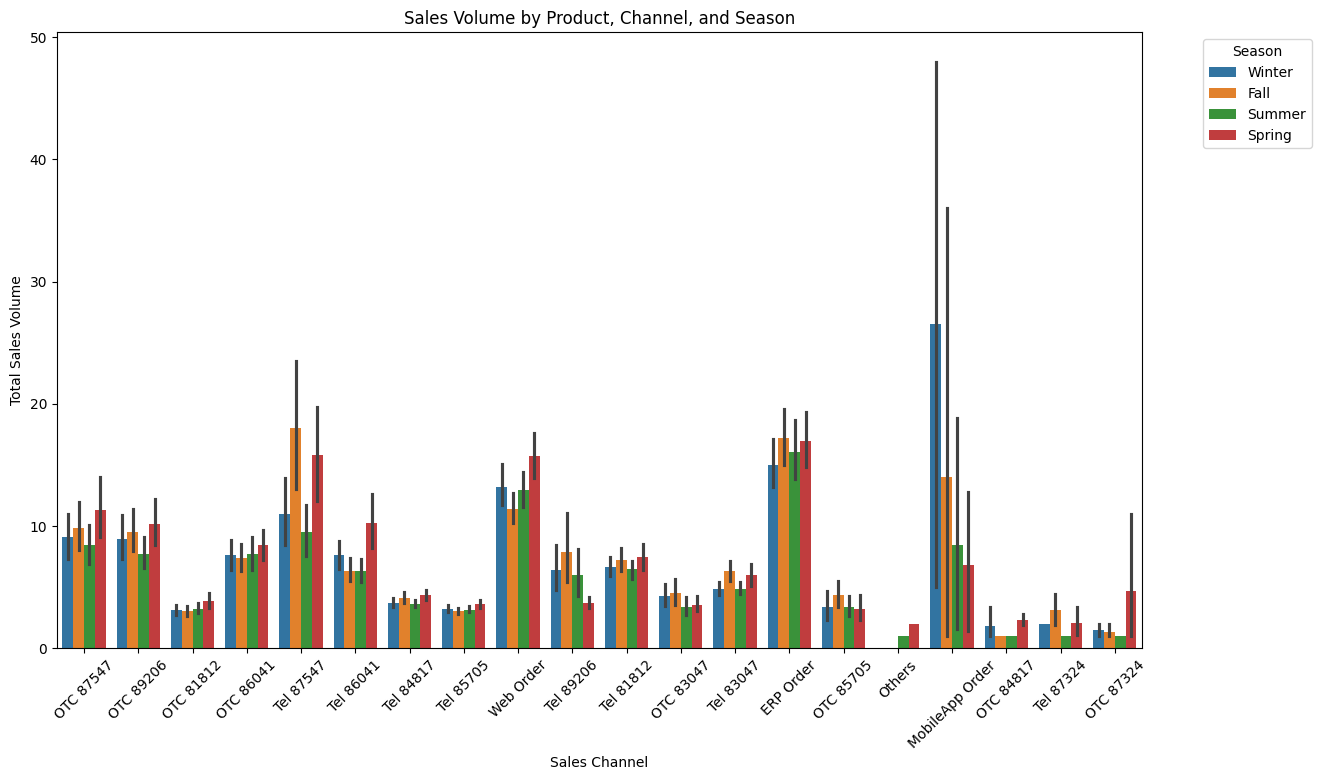

In [241]:
# Aggregating sales volume by product, channel, and season
product_channel_season_sales = df_ut.groupby(['articlenr', 'channel', 'season'])['volume'].sum().reset_index()

# Plotting sales distribution for each product across channels and seasons
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
sns.barplot(data=product_channel_season_sales, x='channel', y='volume', hue='season')
plt.title('Sales Volume by Product, Channel, and Season')
plt.xlabel('Sales Channel')
plt.ylabel('Total Sales Volume')
plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


This chart will help me see if there are any seasonal trends in specific channels for the top-performing products.

Here I will start building new features to analyse the influence of seasons on the sales volume per channel.

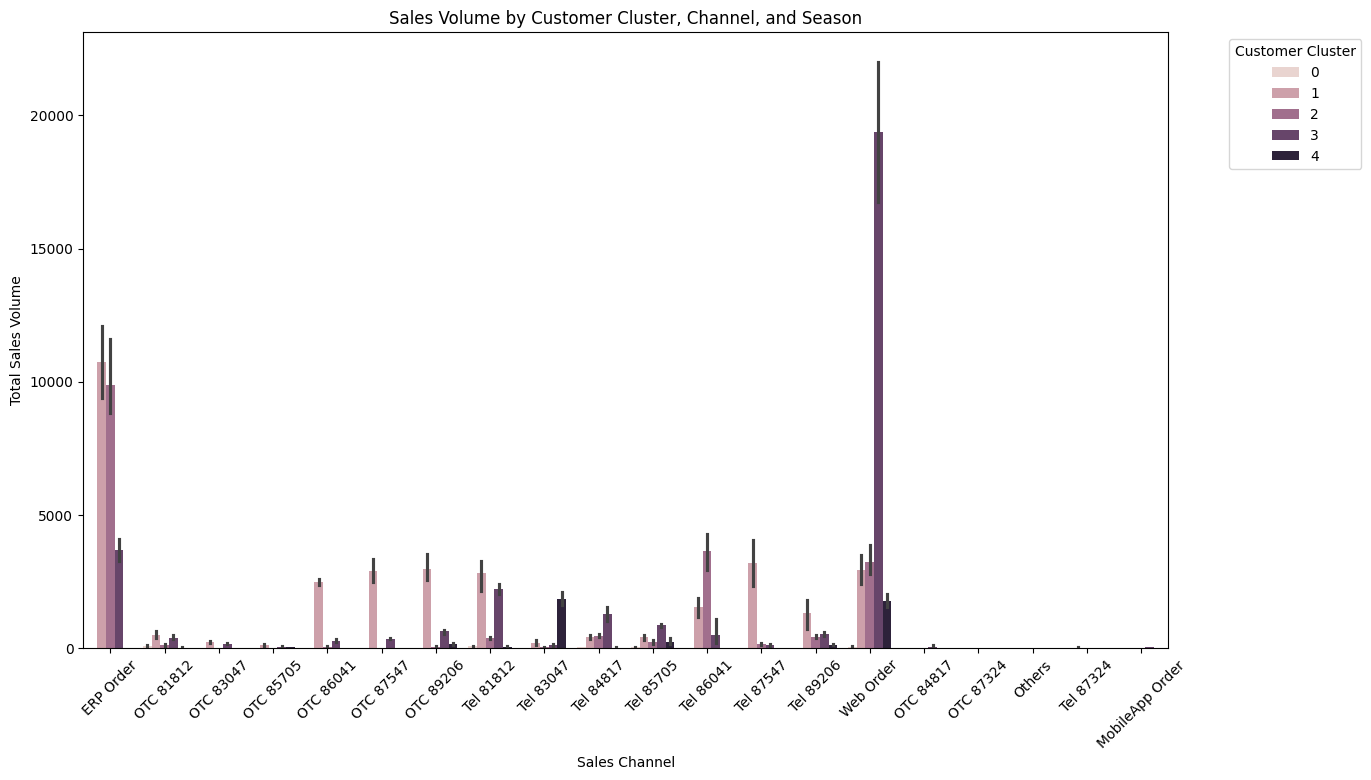

In [62]:
# Aggregating sales volume by cluster, channel, and season
cluster_channel_season_sales = df_ut.groupby(['seasonal_cluster', 'channel', 'season'])['volume'].sum().reset_index()

# Plotting sales volume distribution across clusters, channels, and seasons
plt.figure(figsize=(14, 8))
sns.barplot(data=cluster_channel_season_sales, x='channel', y='volume', hue='seasonal_cluster')
plt.title('Sales Volume by Customer Cluster, Channel, and Season')
plt.xlabel('Sales Channel')
plt.ylabel('Total Sales Volume')
plt.legend(title='Customer Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


This chart shows whether specific customer clusters are more active in certain channels or during certain seasons, providing insights into the behavior of different customer segments.

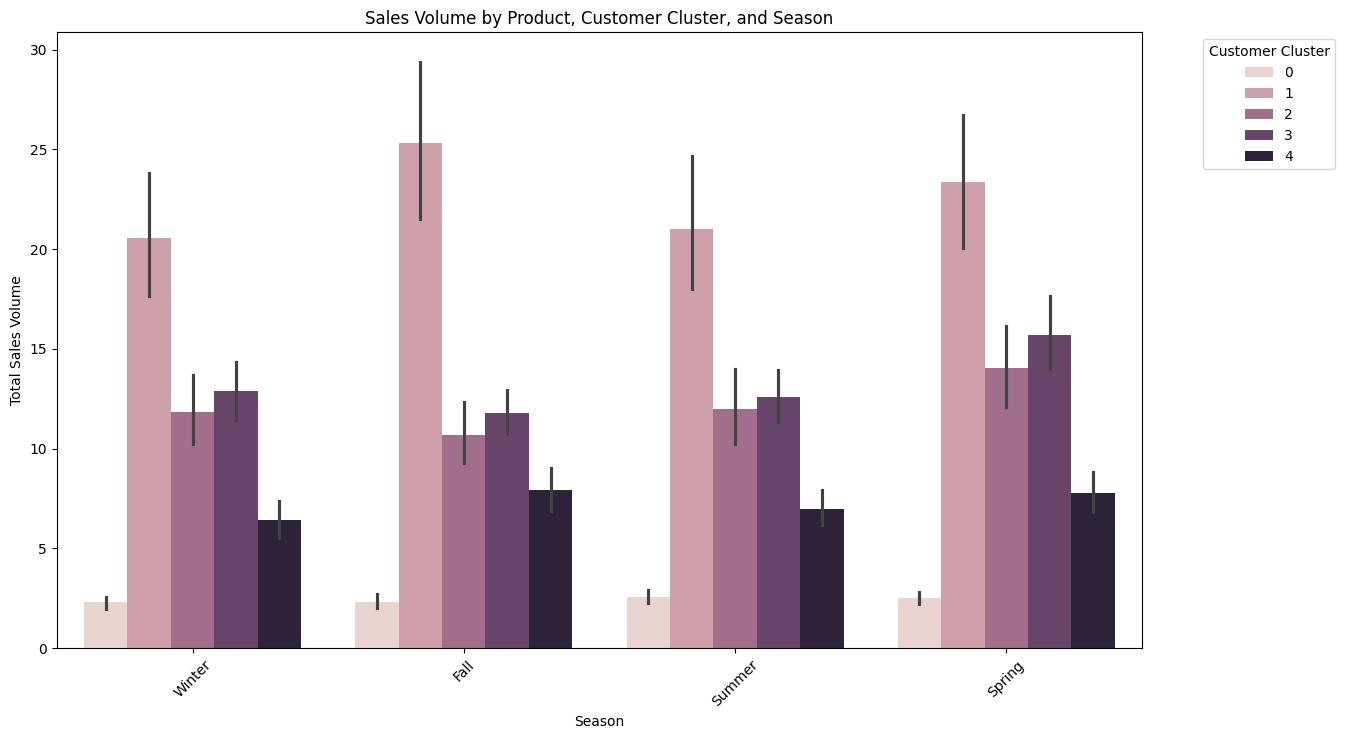

In [63]:
# Aggregating sales volume by product, cluster, and season
cluster_product_season_sales = df_ut.groupby(['articlenr', 'seasonal_cluster', 'season'])['volume'].sum().reset_index()

# Plotting sales distribution for each product across customer clusters and seasons
plt.figure(figsize=(14, 8))
sns.barplot(data=cluster_product_season_sales, x='season', y='volume', hue='seasonal_cluster')
plt.title('Sales Volume by Product, Customer Cluster, and Season')
plt.xlabel('Season')
plt.ylabel('Total Sales Volume')
plt.legend(title='Customer Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


This plot displays the total sales volume segmented by customer cluster across different seasons (Winter, Fall, Summer, and Spring). Each color represents a distinct customer cluster, providing insights into how each group contributes to sales volume over the year.

Cluster 1 (Light Pink):
This cluster consistently shows the highest sales volume across all seasons.
Peak in Fall: Cluster 1 has a notable peak in sales volume during Fall, followed by high activity in Winter and Summer, with Spring being slightly lower.
Interpretation: Cluster 1 likely represents the most active or high-value customers, who are particularly engaged in Fall. This could indicate that customers in this cluster might respond well to promotions around this season.

Cluster 2 (Pink):
This cluster also shows significant sales volumes across seasons, though consistently lower than Cluster 1.
Even Distribution: Cluster 2’s sales volume is relatively balanced across Winter, Fall, and Spring, with a slight dip in Summer.
Interpretation: Cluster 2 appears to represent customers with steady purchasing behavior throughout the year. Seasonal promotions could have a consistent impact on this group, especially in Winter and Fall.

Cluster 3 (Purple):
shows moderate sales volume, but significantly less than Clusters 1 and 2.
Stable with Lower Peaks: This group has fairly consistent sales across Winter, Fall, and Summer, with a slight dip in Spring.
Interpretation: Cluster 3 likely consists of moderate-engagement customers who might respond to seasonal incentives but are not as active as Clusters 1 and 2. Focusing on Winter and Fall promotions may increase their engagement.

Cluster 4 (Dark Purple):
has the lowest sales volume across all seasons, indicating a group with minimal engagement.
Consistent Low Engagement: This cluster’s sales volume is low and relatively flat across the seasons, with no distinct peaks.
Interpretation: Cluster 4 likely represents low-engagement or occasional customers. It may be challenging to increase their sales volume significantly through seasonal promotions.
Cluster 0 (Very Light Pink):

Cluster 0 shows minimal activity across all seasons, with a small peak in Spring and low engagement otherwise.
Interpretation: Similar to Cluster 4, Cluster 0 might represent low-value or infrequent buyers. This cluster may not be highly responsive to typical seasonal promotions and might require targeted efforts if they are worth activating.